# ===========================
# Benchmarking UMAP 
### UMAP parameter evaluation for Correlation Coefficient
# ===========================

In [4]:
from multidimvis_main import *

## GRAPHS

### TOYMODELS

In [17]:
################################################
#
# C A Y L E Y T R E E 
#
################################################

organism = 'tree'
n = 1093 
r = 3
G = nx.full_rary_tree(r,n)


# NETWORK DISTANCE

dist_network = {}
for a in nx.shortest_path_length(G):
    for n,spl in a[1].items():
        dist_network[(a[0],n)] = spl

In [10]:
################################################
#
# C U B E G R I D
#
################################################

organism = 'grid'

G = nx.grid_graph([10,10,10],periodic=False)


# NETWORK DISTANCE

dist_network = {}
for a in nx.shortest_path_length(G):
    for n,spl in a[1].items():
        dist_network[(a[0],n)] = spl

In [21]:
################################################
#
# T O R U S L A T T I C E 
#
################################################

organism = 'torus'

G = nx.grid_2d_graph(44,22,periodic=True)


# NETWORK DISTANCE

dist_network = {}
for a in nx.shortest_path_length(G):
    for n,spl in a[1].items():
        dist_network[(a[0],n)] = spl

Degree min: 4
Degree max: 4
Degree counts: {4: 968}
Degree Mean: 4.0
Degree Variant: 0.0


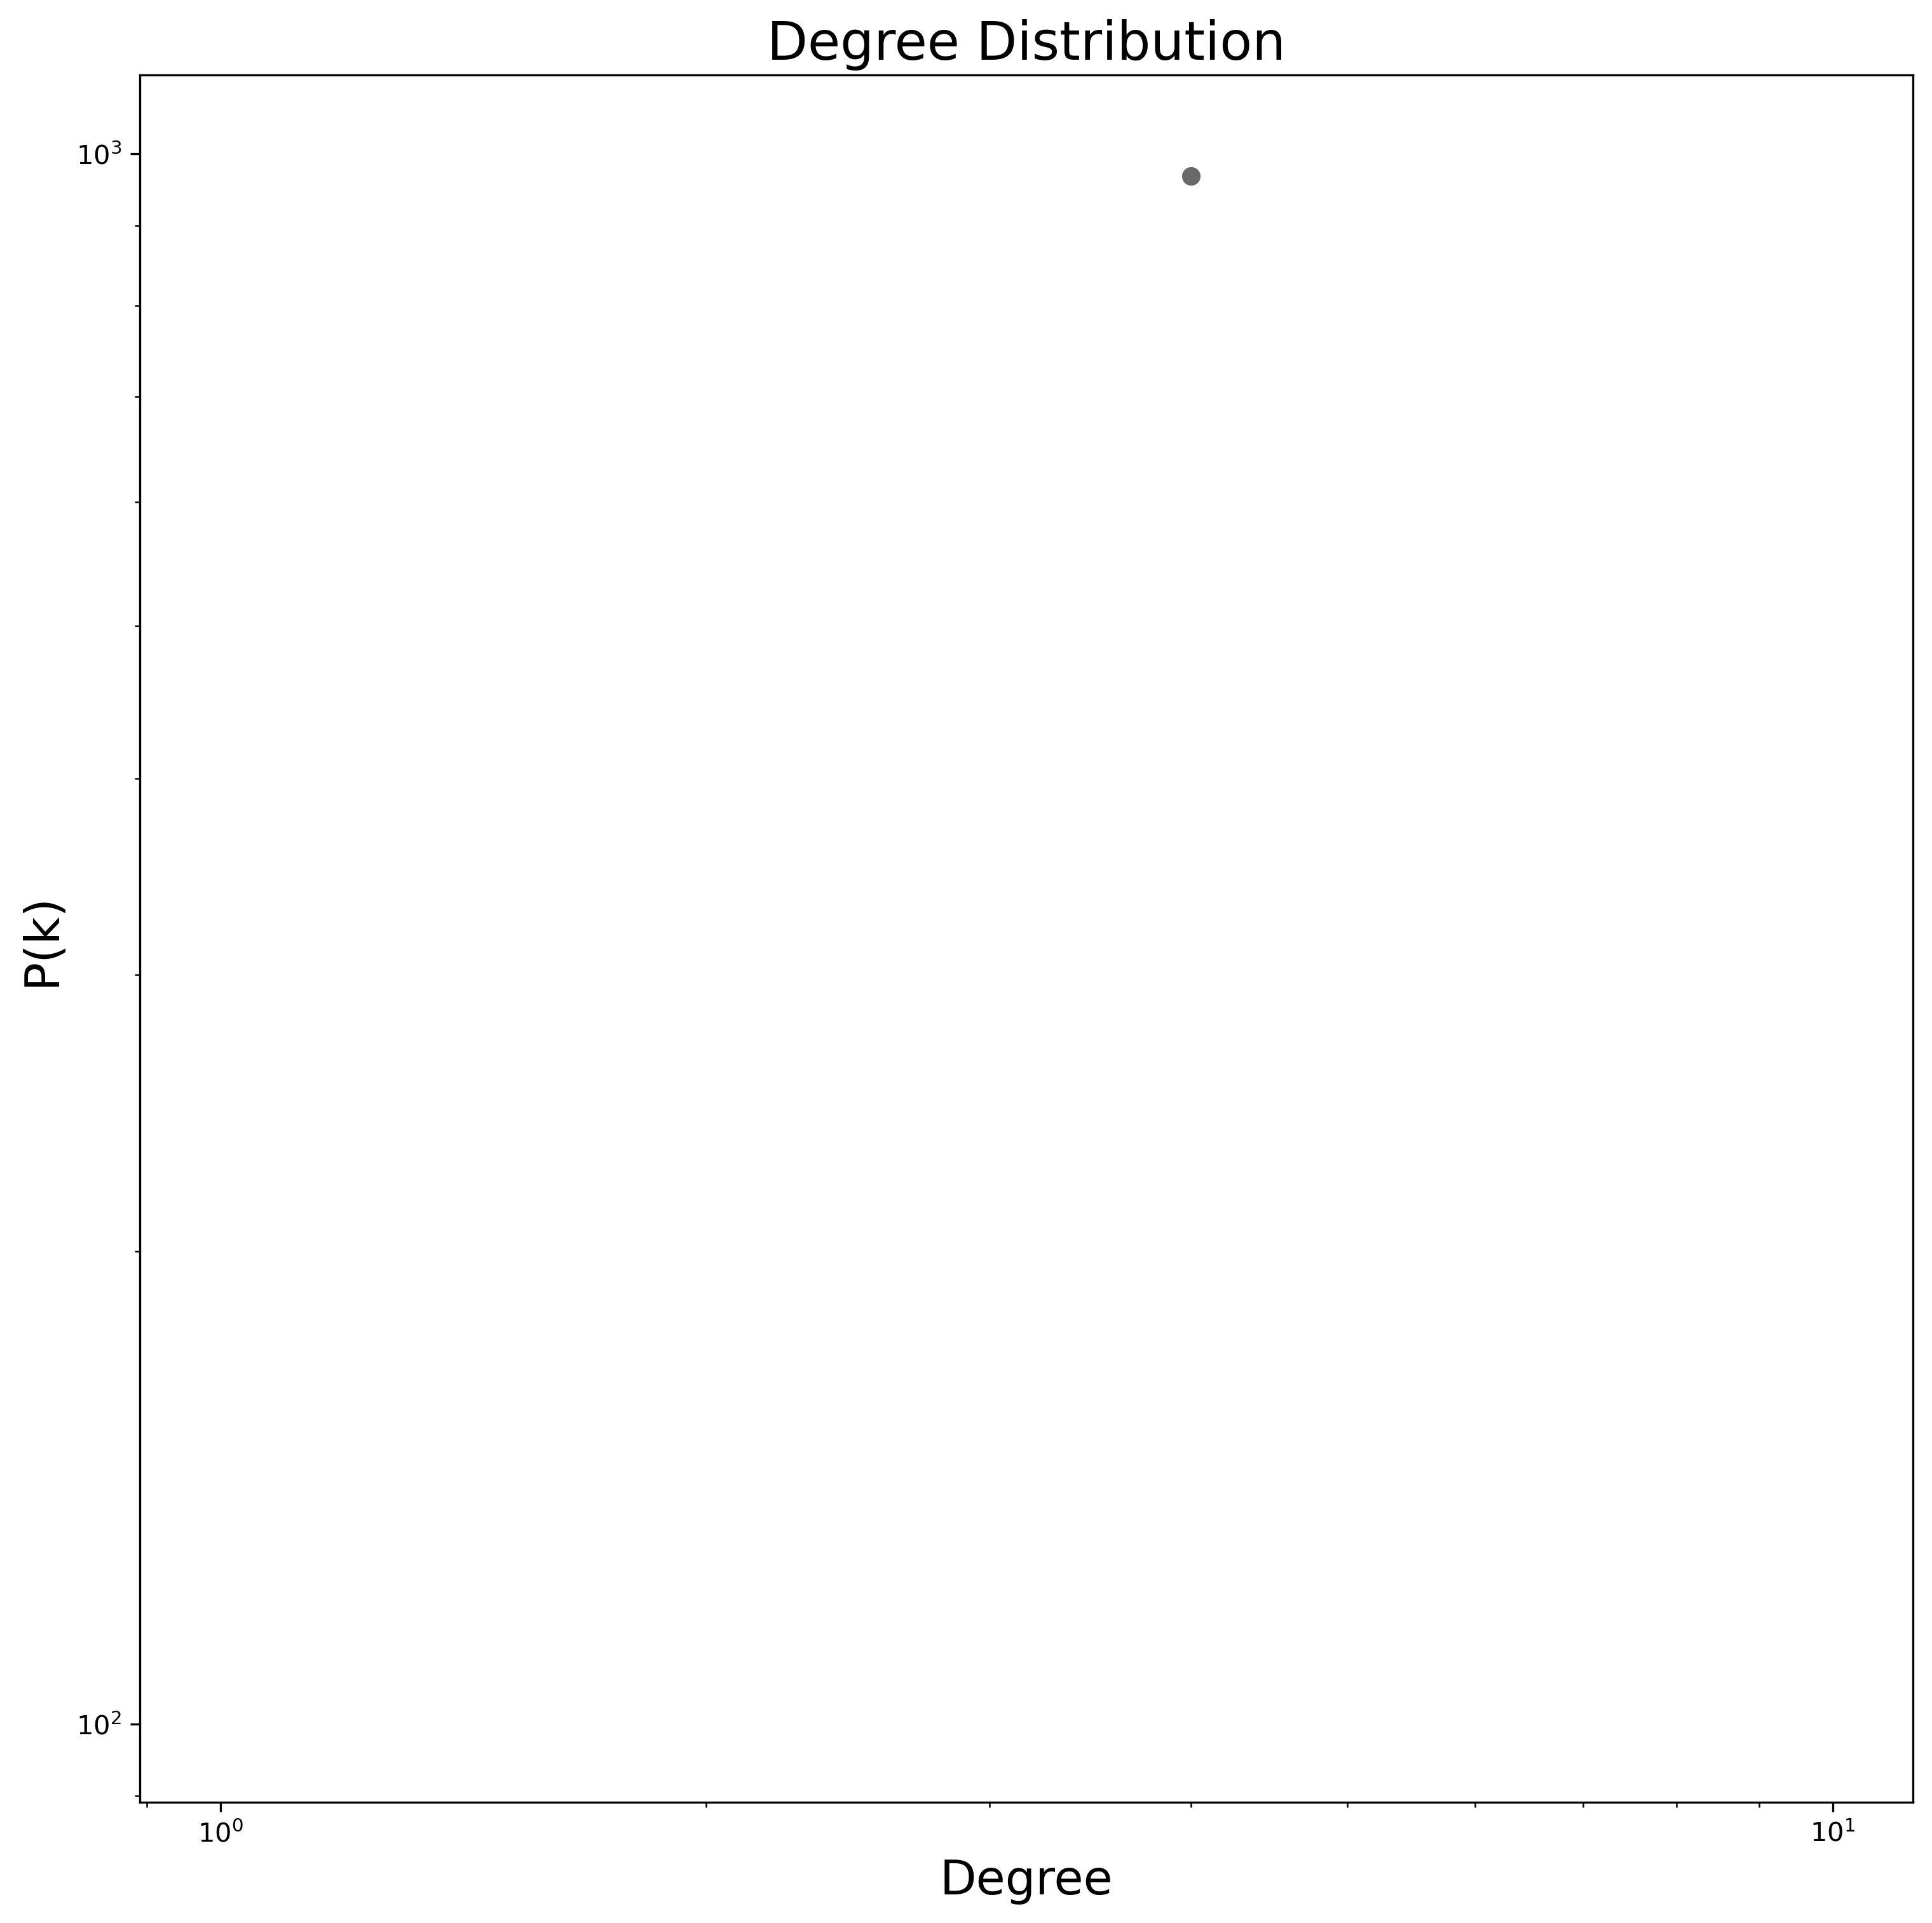

<Figure size 432x288 with 0 Axes>

In [22]:
degs = dict(G.degree())

l_k = list(degs.values())
set_k = set(l_k)
print('Degree min:', min(l_k))
print('Degree max:', max(l_k))

d_k_f = {}
for k in set_k:
    d_k_f[k] = l_k.count(k)
print('Degree counts:',d_k_f)

mean_deg = np.mean(l_k)
var_deg = np.var(l_k)
print('Degree Mean:', mean_deg)
print('Degree Variant:', var_deg)

plt.figure(figsize=(12,12), dpi=300)
plt.title('Degree Distribution', fontsize = 20)
plt.xlabel('Degree', fontsize = 18)
plt.ylabel('P(k)', fontsize = 18)
plt.loglog(list(d_k_f.keys()),list(d_k_f.values()),'o',c='dimgrey')
plt.loglog(list(d_k_f.keys()),list(d_k_f.values()),'--',c='grey')
plt.show()

plt.savefig('DegreeDistribution_'+organism+'.png')

In [78]:
print('Network:', organism)
print('Number of nodes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
print('Network density: %.11f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Network: torus
Number of nodes: 968
Number of edges: 1936
Network density: 0.41322358149%


_________

# EVALUATION - 2D


### UMAP - RWR

### Impact of UMAP PARAMETERS to CORRELATION COEFFICIENT (of Network Dist / Layout Dist) 
+ number of neighbors 
+ n_epochs
+ learning rate 
+ spread 
+ min_dist

In [6]:
feature = 'RWRvis'

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 20 
spread = 1
min_dist = 0.0 
metric ='cosine'
lnr = 1 
nep = None

r = 0.9
a = 1

#### ------ NUMBER OF NEIGHBORS ------
+ The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation
+ Larger values result in more global views of the manifold, while smaller values result in more local data being preserved 
+ In general values should be in the range 2 to 100.

In [34]:
# NUMBER OF NEIGHBORS 

n_neighbor_list = [4,8,12,16,20,50,100,200]

d_rwr_neigh = {}
d_r_values_rwr_neigh = {}

for i in n_neighbor_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, a, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m.T

    umap_rwr = embed_umap_2D(DM_rwr, i, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)
    
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T
    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)
    
    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    end = time.time()

    print('UMAP n_neighs:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_neigh[i] = walltime_rwr
    
    posG=posG_complete_umap_rwr_norm
    dist_layout2D = {} 
    for p1,p2 in it.combinations(G.nodes(),2):
        dist_layout2D[(p1,p2)] = np.sqrt((posG[p1][0]-posG[p2][0])**2+(posG[p1][1]-posG[p2][1])**2)

    dist_network_mod = {}
    for j,m in dist_network.items():
        if j in dist_layout2D.keys():
            dist_network_mod[j]=float(m)

    d_plot_layout = {}
    for spldist in range(1,int(max(dist_network_mod.values()))+1):
        l_s = []
        for k, v in dist_network_mod.items():
            if v == spldist:
                l_s.append(k)
        l_xy = []
        for nodes in l_s:
            dxy = dist_layout2D[nodes]
            l_xy.append(dxy)
        d_plot_layout[spldist] = l_xy


    l_medians_layout = []
    for k, v in d_plot_layout.items():
        l_medians_layout.append(statistics.median(v))

    x = np.array(range(1,int(max(dist_network_mod.values()))+1))
    y = np.array(l_medians_layout)
    r_layout = np.corrcoef(x, y)

    print('GLOBAL (RWR) Pearson Correlation Factor: ', r_layout[0][1])

    d_r_values_rwr_neigh[i] = r_layout[0][1]

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/spectral.py:255: UserWarning:

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!



UMAP n_neighs: 4
Execution Time: 00:00:04
min: 0 sec: 4
GLOBAL (RWR) Pearson Correlation Factor:  0.9586304964454674
UMAP n_neighs: 8
Execution Time: 00:00:04
min: 0 sec: 4
GLOBAL (RWR) Pearson Correlation Factor:  0.9770359815326843
UMAP n_neighs: 12
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9779709468184041
UMAP n_neighs: 16
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9382752968543919
UMAP n_neighs: 20
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9466443810301955
UMAP n_neighs: 50
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.8581019218003229
UMAP n_neighs: 100
Execution Time: 00:00:06
min: 0 sec: 6
GLOBAL (RWR) Pearson Correlation Factor:  0.8378835490972274
UMAP n_neighs: 200
Execution Time: 00:00:08
min: 0 sec: 8
GLOBAL (RWR) Pearson Correlation Factor:  0.9002205183971076


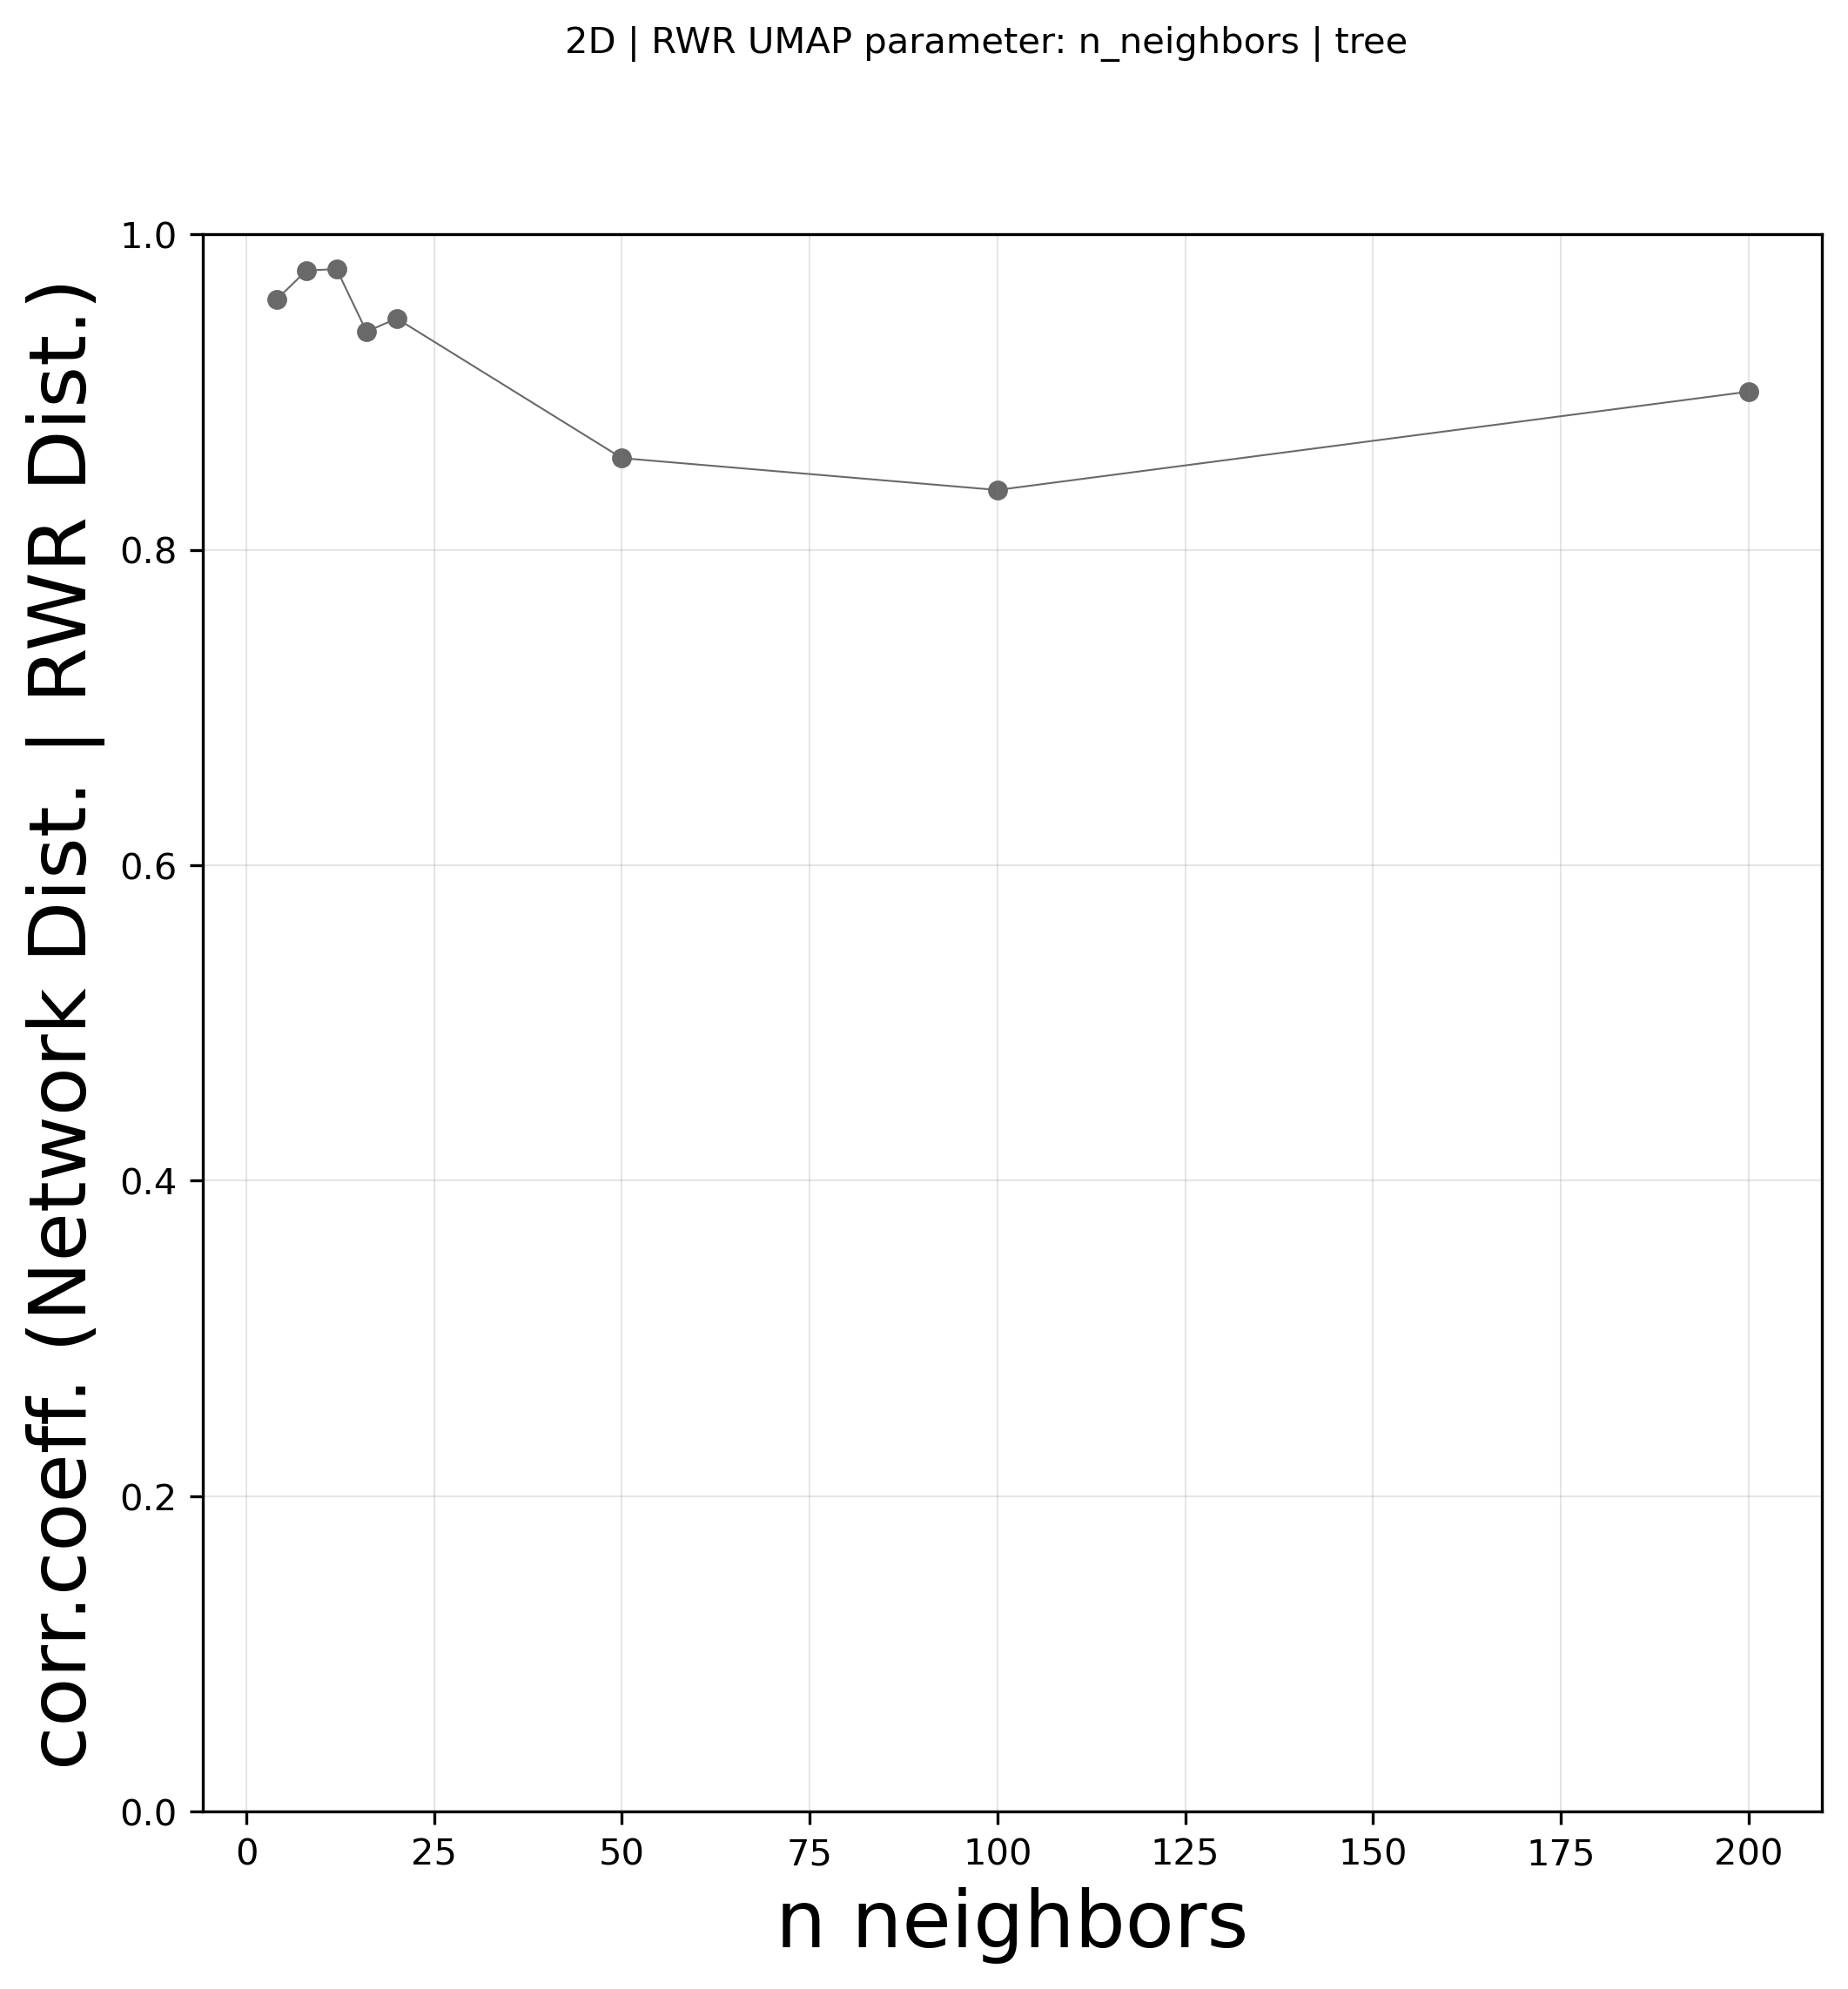

In [37]:
x = list(d_rwr_neigh.keys())
y = list(d_r_values_rwr_neigh.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.suptitle('2D | RWR UMAP parameter: n_neighbors | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

plt.xlabel("n neighbors", fontsize = 22)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize = 22)
plt.grid(True, c='grey', alpha=0.2, linewidth=0.5)

plt.plot(x,y, '-', c = 'dimgrey', linewidth=0.5, alpha = 1.0)
plt.scatter(x,y, c = 'dimgrey', s = 20, alpha = 1.0)

fig.savefig('output_plots/benchmark/Correlation2D_neighs_'+feature+'_'+organism+'.png')

In [38]:
#adjust parameters 

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 12
spread = 1.0
min_dist = 0.0
metric ='cosine'
lnr = 1
nep = None

#### ------ MIN DIST ------
+ The effective minimum distance between embedded points
+ Smaller values will result in a more clustered/clumped embedding where nearby points on the manifold are drawn closer together, while larger values will result on a more even dispersal of points

In [40]:
# MIN DIST 

mindist_list = [0.001,0.01,0.1,0.5,0.9,1]

d_rwr_mdist = {}
d_r_values_rwr_mdist = {}

for i in mindist_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, a, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m.T

    umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, spread, i, metric, learn_rate = lnr, n_ep = nep)
    
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T
    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)
    
    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    end = time.time()
    
    print('UMAP min dist:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_mdist[i] = walltime_rwr
     
    posG=posG_complete_umap_rwr_norm
    dist_layout2D = {} 
    for p1,p2 in it.combinations(G.nodes(),2):
        dist_layout2D[(p1,p2)] = np.sqrt((posG[p1][0]-posG[p2][0])**2+(posG[p1][1]-posG[p2][1])**2)

    dist_network_mod = {}
    for j,m in dist_network.items():
        if j in dist_layout2D.keys():
            dist_network_mod[j]=float(m)

    d_plot_layout = {}
    for spldist in range(1,int(max(dist_network_mod.values()))+1):
        l_s = []
        for k, v in dist_network_mod.items():
            if v == spldist:
                l_s.append(k)
        l_xy = []
        for nodes in l_s:
            dxy = dist_layout2D[nodes]
            l_xy.append(dxy)
        d_plot_layout[spldist] = l_xy


    l_medians_layout = []
    for k, v in d_plot_layout.items():
        l_medians_layout.append(statistics.median(v))

    x = np.array(range(1,int(max(dist_network_mod.values()))+1))
    y = np.array(l_medians_layout)
    r_layout = np.corrcoef(x, y)

    print('GLOBAL (RWR) Pearson Correlation Factor: ', r_layout[0][1])

    d_r_values_rwr_mdist[i] = r_layout[0][1]

UMAP min dist: 0.001
Execution Time: 00:00:04
min: 0 sec: 4
GLOBAL (RWR) Pearson Correlation Factor:  0.9730819236840657
UMAP min dist: 0.01
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9772802508345406
UMAP min dist: 0.1
Execution Time: 00:00:04
min: 0 sec: 4
GLOBAL (RWR) Pearson Correlation Factor:  0.9766510207372359
UMAP min dist: 0.5
Execution Time: 00:00:04
min: 0 sec: 4
GLOBAL (RWR) Pearson Correlation Factor:  0.9783785730092286
UMAP min dist: 0.9
Execution Time: 00:00:04
min: 0 sec: 4
GLOBAL (RWR) Pearson Correlation Factor:  0.9769245379941426
UMAP min dist: 1
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9756368884264293


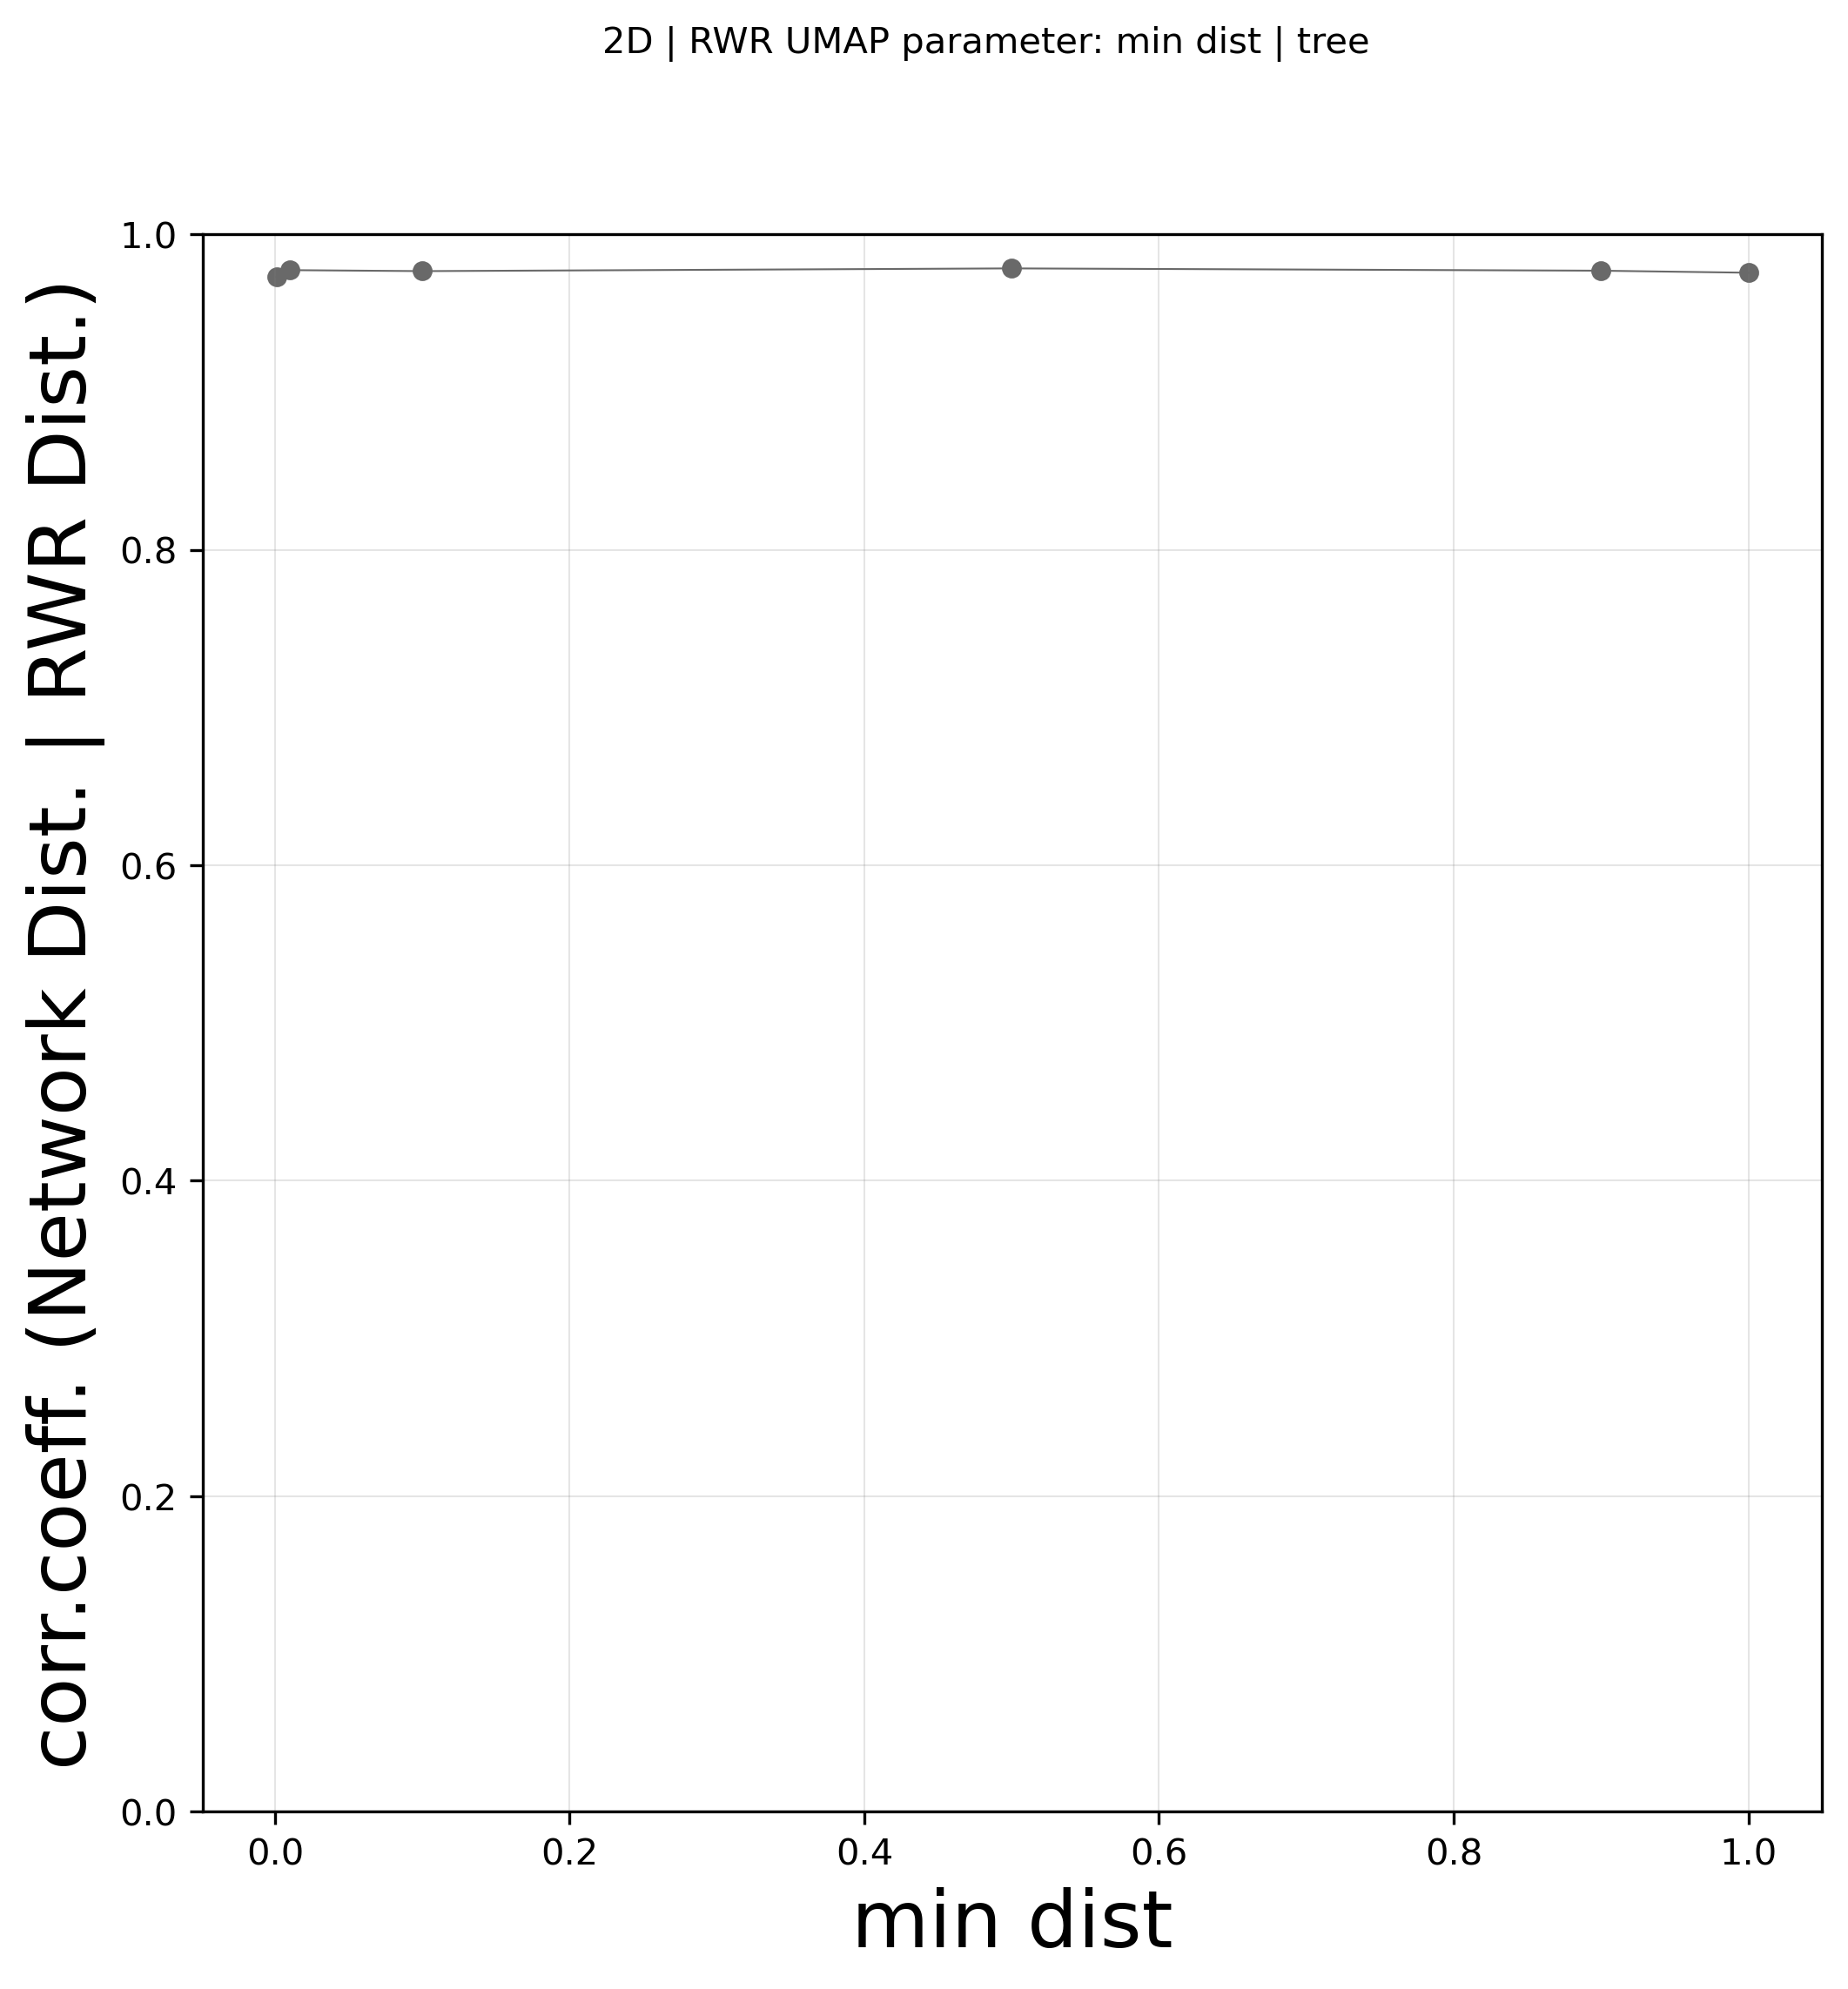

In [41]:
x = list(d_rwr_mdist.keys())
y = list(d_r_values_rwr_mdist.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.suptitle('2D | RWR UMAP parameter: min dist | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

plt.xlabel("min dist", fontsize = 22)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize = 22)
plt.grid(True, c='grey', alpha=0.2, linewidth=0.5)

plt.plot(x,y, '-', c = 'dimgrey', linewidth=0.5, alpha = 1.0)
plt.scatter(x,y, c = 'dimgrey', s = 20, alpha = 1.0)

fig.savefig('output_plots/benchmark/Correlation_mindist_'+feature+'_'+organism+'.png')

In [42]:
#adjust parameters 

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 12
spread = 1
min_dist = 0.5
metric = 'cosine'
lnr = 1
nep = None

#### ------ SPREAD ------
+ The effective scale of embedded points
+ In combination with min_dist this determines how clustered/clumped the embedded points are

In [44]:
# SPREAD

spread_list = [0.9,1,2,3,4,5,6,7,8,9,10]

d_rwr_spread = {}
d_r_values_rwr_spread  = {}

for i in spread_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m.T

    umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, i, min_dist, metric, learn_rate = lnr, n_ep = nep)
    
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T
    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)
    
    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    end = time.time()

    print('UMAP spread:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_spread[i] = walltime_rwr

    posG=posG_complete_umap_rwr_norm
    dist_layout2D = {} 
    for p1,p2 in it.combinations(G.nodes(),2):
        dist_layout2D[(p1,p2)] = np.sqrt((posG[p1][0]-posG[p2][0])**2+(posG[p1][1]-posG[p2][1])**2)

    dist_network_mod = {}
    for j,m in dist_network.items():
        if j in dist_layout2D.keys():
            dist_network_mod[j]=float(m)

    d_plot_layout = {}
    for spldist in range(1,int(max(dist_network_mod.values()))+1):
        l_s = []
        for k, v in dist_network_mod.items():
            if v == spldist:
                l_s.append(k)
        l_xy = []
        for nodes in l_s:
            dxy = dist_layout2D[nodes]
            l_xy.append(dxy)
        d_plot_layout[spldist] = l_xy


    l_medians_layout = []
    for k, v in d_plot_layout.items():
        l_medians_layout.append(statistics.median(v))

    x = np.array(range(1,int(max(dist_network_mod.values()))+1))
    y = np.array(l_medians_layout)
    r_layout = np.corrcoef(x, y)

    print('GLOBAL (RWR) Pearson Correlation Factor: ', r_layout[0][1])

    d_r_values_rwr_spread[i] = r_layout[0][1]

UMAP spread: 0.9
Execution Time: 00:00:08
min: 0 sec: 8
GLOBAL (RWR) Pearson Correlation Factor:  0.9756182156974812
UMAP spread: 1
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9783785730092286
UMAP spread: 2
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9802988677786985
UMAP spread: 3
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9812932370699361


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 4
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9821515878831762


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 5
Execution Time: 00:00:06
min: 0 sec: 6
GLOBAL (RWR) Pearson Correlation Factor:  0.9828498261781201


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 6
Execution Time: 00:00:06
min: 0 sec: 6
GLOBAL (RWR) Pearson Correlation Factor:  0.9844827527158937


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 7
Execution Time: 00:00:06
min: 0 sec: 6
GLOBAL (RWR) Pearson Correlation Factor:  0.9845980577150669


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 8
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9827108511202118


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 9
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9846206038388561


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 10
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.984090432029172


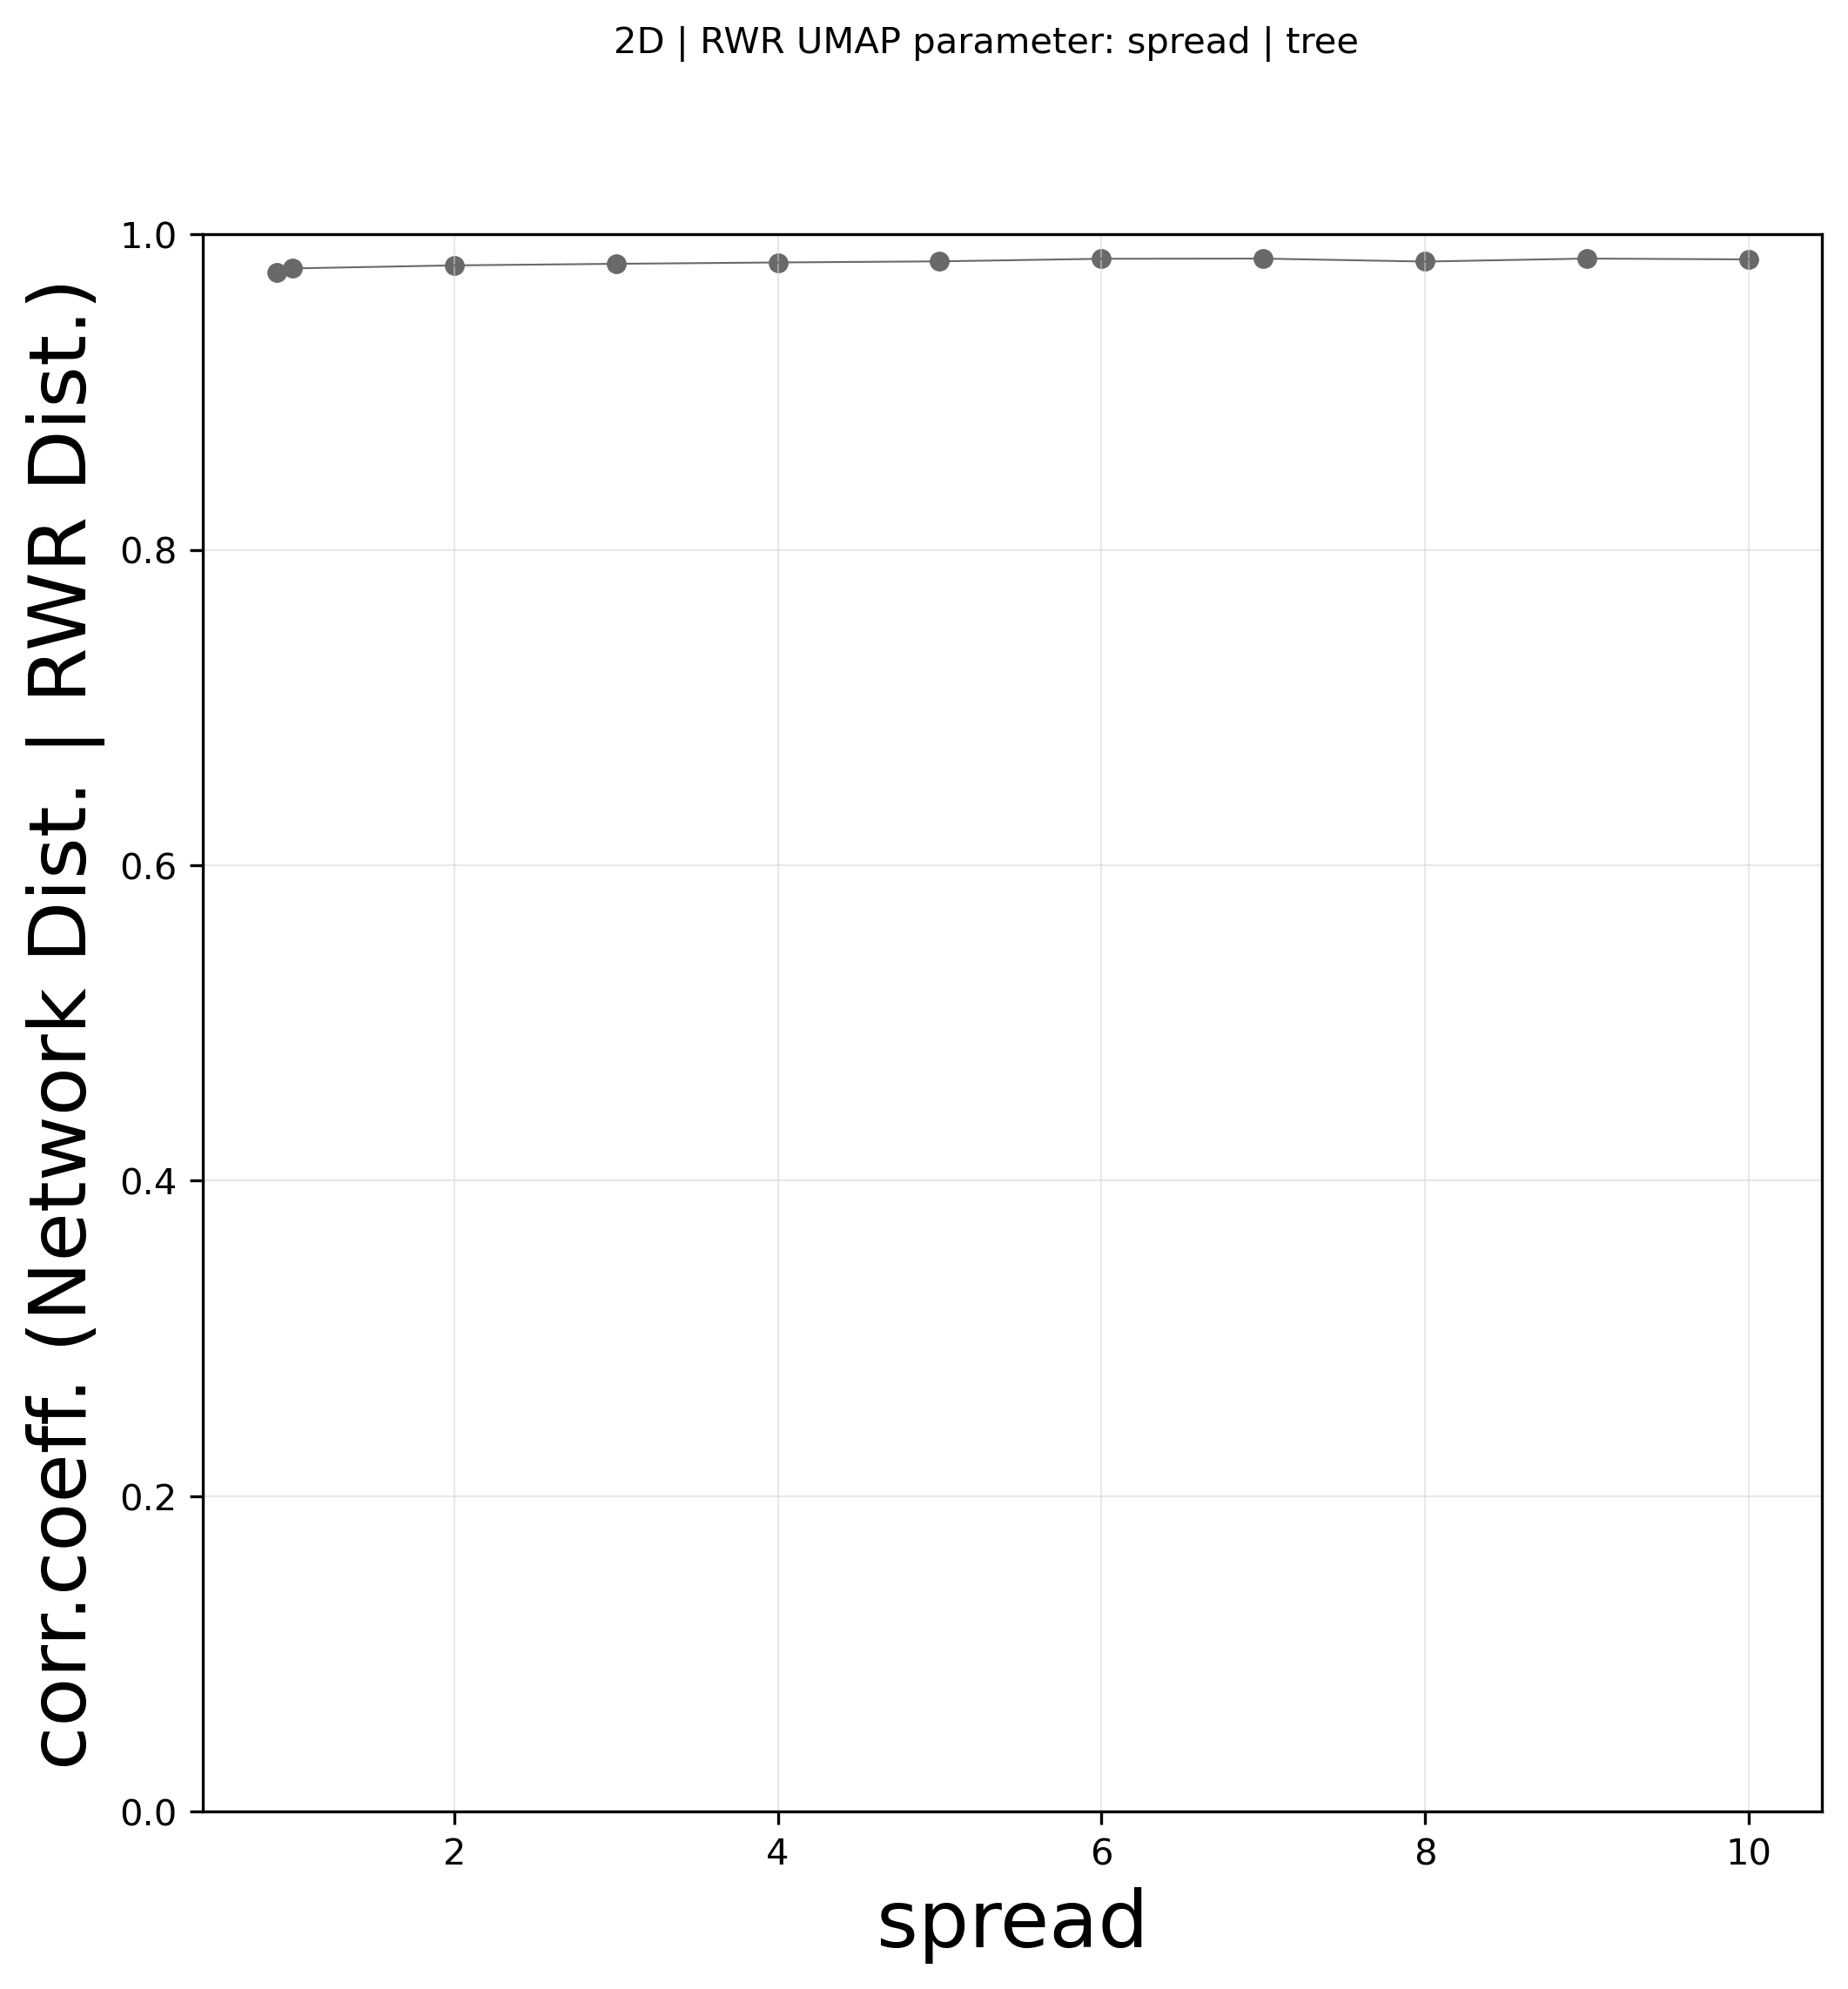

In [46]:
x = list(d_rwr_spread.keys())
y = list(d_r_values_rwr_spread.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.ylim(ymin=0, ymax=1.0)
plt.xlabel("spread", fontsize=22)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=22)
plt.grid(True, c='grey', alpha=0.2, linewidth=0.5)

plt.plot(x,y, '-', c = 'dimgrey', linewidth=0.5, alpha = 1.0)
plt.scatter(x,y, c = 'dimgrey', s = 20, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | RWR UMAP parameter: spread | '+organism, fontsize=10)

fig.savefig('output_plots/benchmark/Correlation_spread_'+feature+'_'+organism+'.png')

In [47]:
#adjust parameters 

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 12
spread = 6
min_dist = 0.5
metric = 'cosine'
lnr = 1
nep = None

#### ------ NUMBER OF EPOCHS ------
+ The number of training epochs to be used in optimizing the low dimensional embedding
+ Larger values result in more accurate embeddings 
+ If None is specified a value will be selected based on the size of the input dataset (200 for large datasets, 500 for small)

In [48]:
# NUMBER OF EPOCHS 

nep_list = [None, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

d_rwr_epochs = {}
d_r_values_rwr_nep = {}

for i in nep_list: 
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m.T

    umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = i)
    
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T
    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)
    
    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    end = time.time()

    print('UMAP n_epoch:' ,i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_epochs[i] = walltime_rwr
    
    posG=posG_complete_umap_rwr_norm
    dist_layout2D = {} 
    for p1,p2 in it.combinations(G.nodes(),2):
        dist_layout2D[(p1,p2)] = np.sqrt((posG[p1][0]-posG[p2][0])**2+(posG[p1][1]-posG[p2][1])**2)

    dist_network_mod = {}
    for j,m in dist_network.items():
        if j in dist_layout2D.keys():
            dist_network_mod[j]=float(m)

    d_plot_layout = {}
    for spldist in range(1,int(max(dist_network_mod.values()))+1):
        l_s = []
        for k, v in dist_network_mod.items():
            if v == spldist:
                l_s.append(k)
        l_xy = []
        for nodes in l_s:
            dxy = dist_layout2D[nodes]
            l_xy.append(dxy)
        d_plot_layout[spldist] = l_xy


    l_medians_layout = []
    for k, v in d_plot_layout.items():
        l_medians_layout.append(statistics.median(v))

    x = np.array(range(1,int(max(dist_network_mod.values()))+1))
    y = np.array(l_medians_layout)
    r_layout = np.corrcoef(x, y)

    print('GLOBAL (RWR) Pearson Correlation Factor: ', r_layout[0][1])

    d_r_values_rwr_nep[i] = r_layout[0][1]    

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_epoch: None
Execution Time: 00:00:06
min: 0 sec: 6
GLOBAL (RWR) Pearson Correlation Factor:  0.9844827527158937


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_epoch: 100
Execution Time: 00:00:04
min: 0 sec: 4
GLOBAL (RWR) Pearson Correlation Factor:  0.9850015604376552


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_epoch: 200
Execution Time: 00:00:04
min: 0 sec: 4
GLOBAL (RWR) Pearson Correlation Factor:  0.9859551908176571


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_epoch: 300
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9854519326928675


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_epoch: 400
Execution Time: 00:00:04
min: 0 sec: 4
GLOBAL (RWR) Pearson Correlation Factor:  0.9842779765284038


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_epoch: 500
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9844827527158937


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_epoch: 600
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9840133856236891


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_epoch: 700
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9846254575310778


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_epoch: 800
Execution Time: 00:00:06
min: 0 sec: 6
GLOBAL (RWR) Pearson Correlation Factor:  0.9834090416605803


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_epoch: 900
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9828732176524243


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP n_epoch: 1000
Execution Time: 00:00:06
min: 0 sec: 6
GLOBAL (RWR) Pearson Correlation Factor:  0.9839444057854647


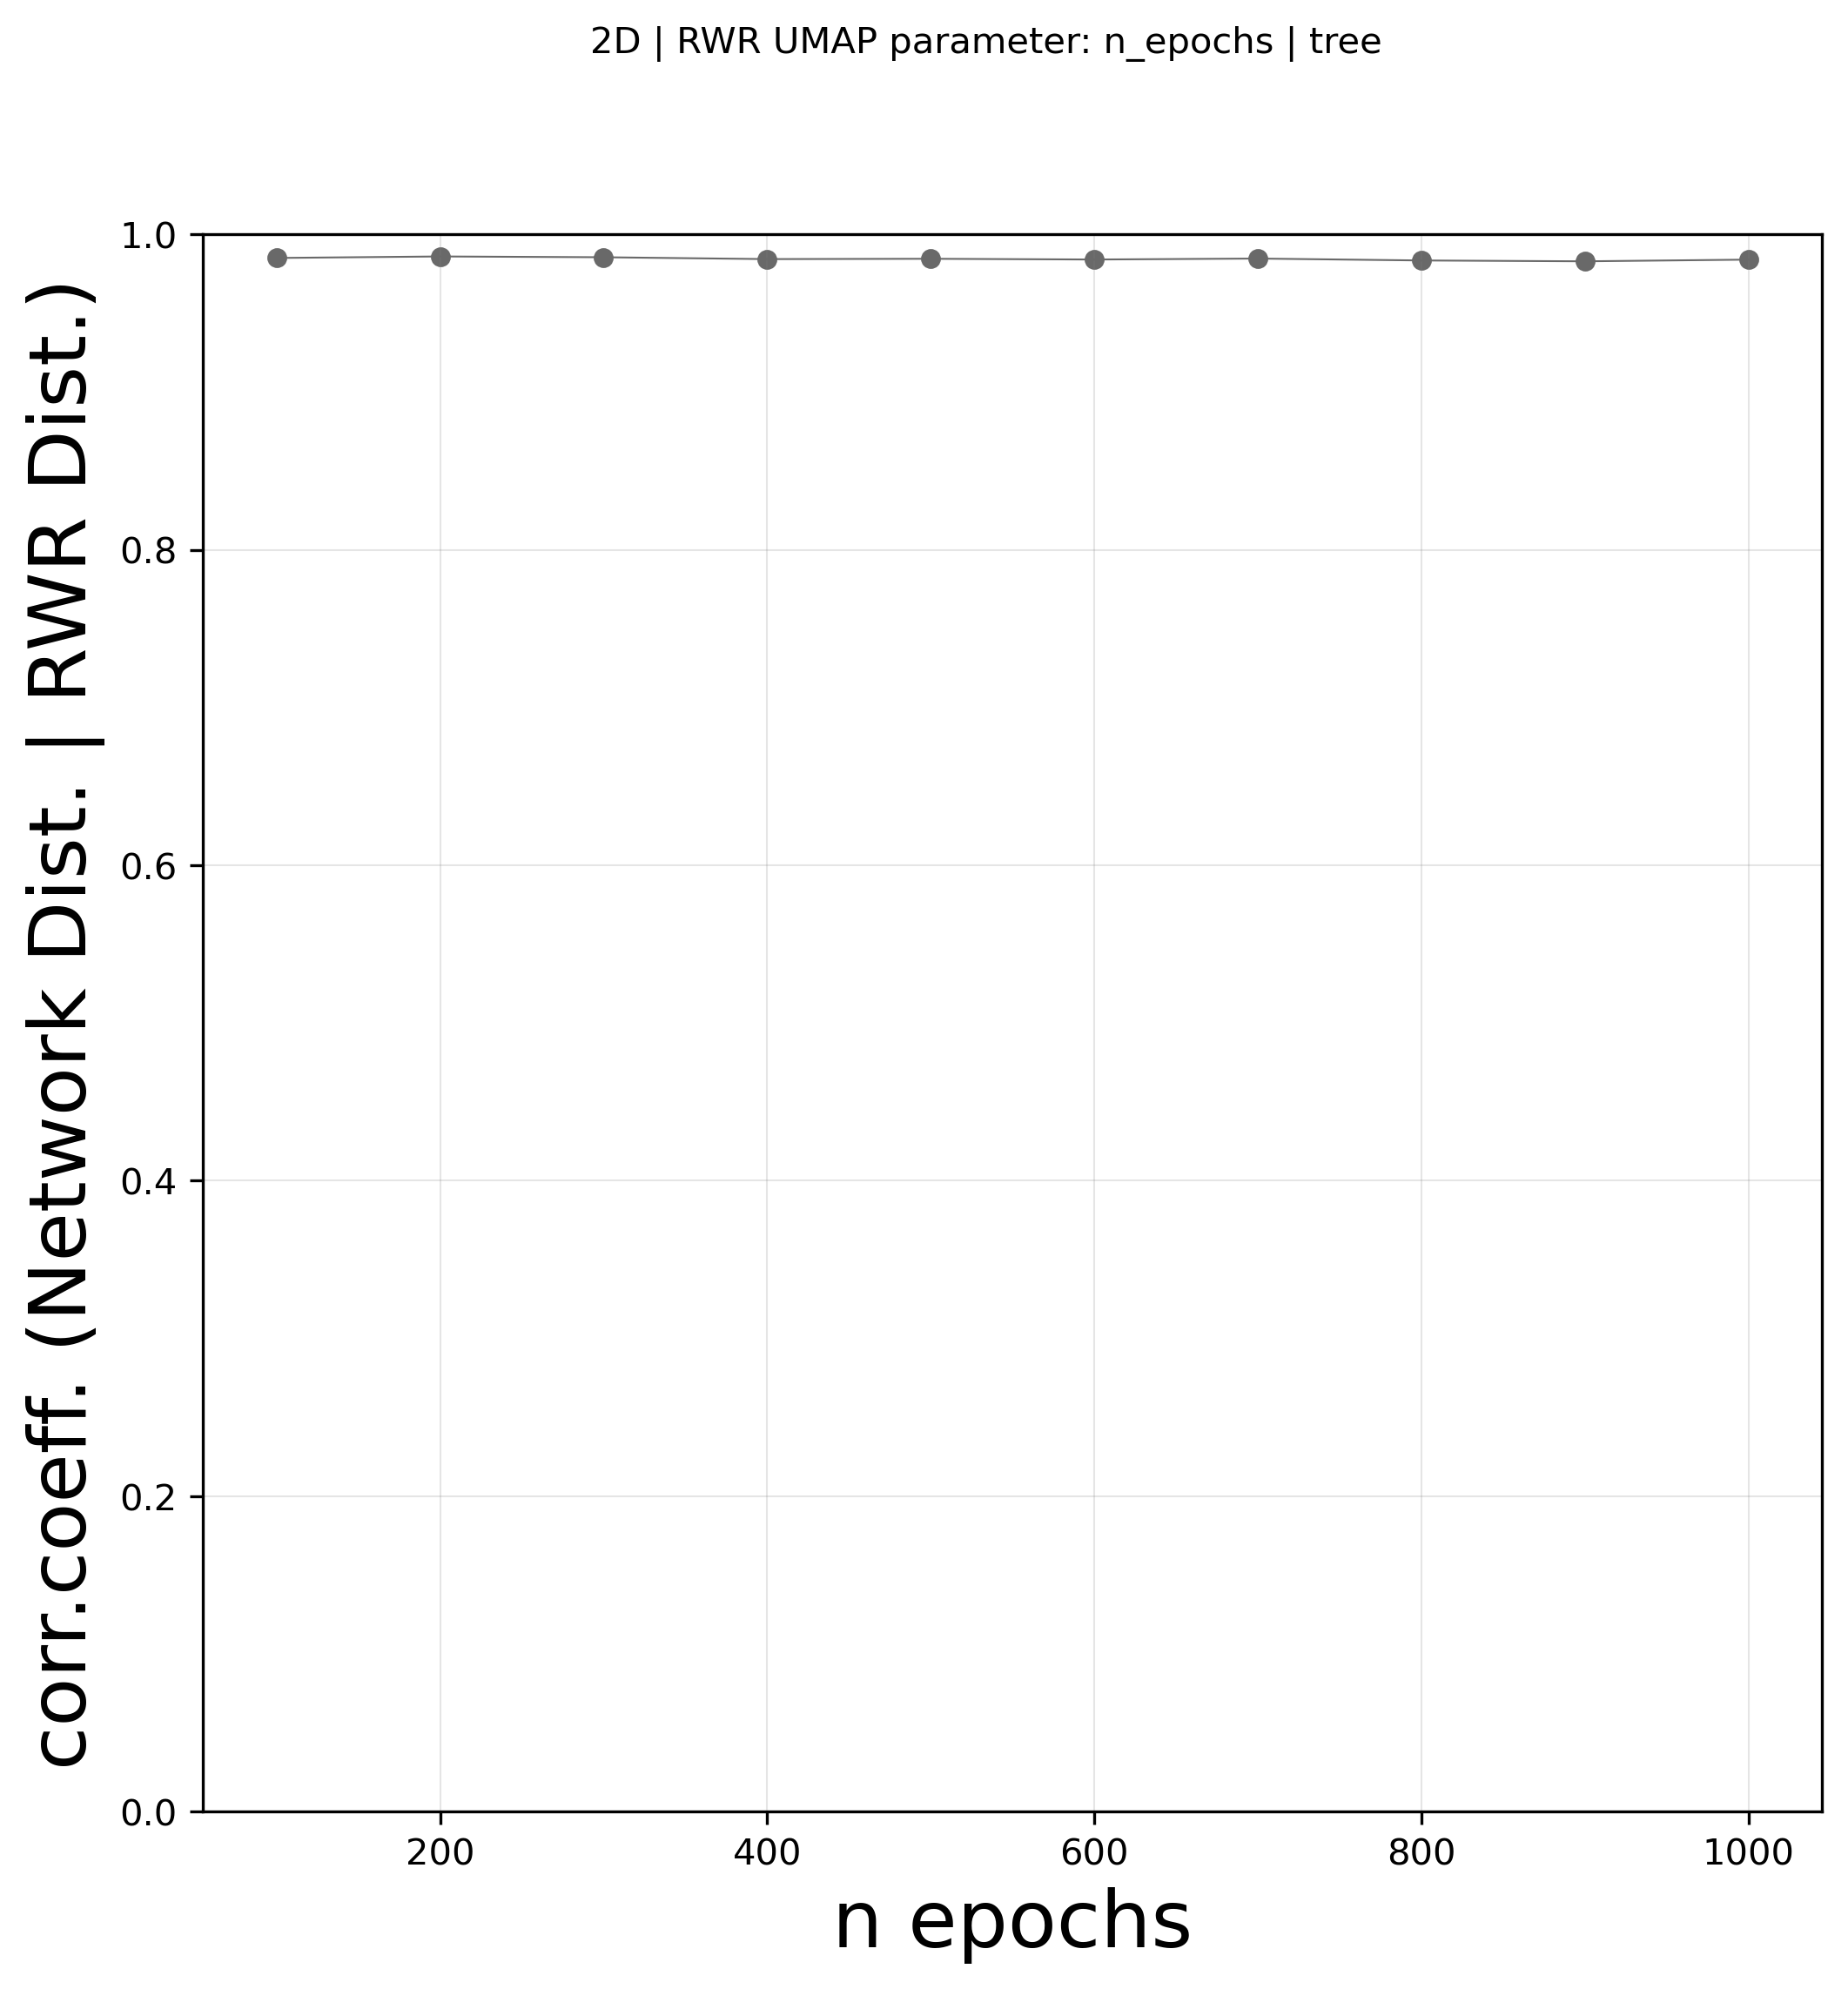

In [50]:
x = list(d_rwr_epochs.keys())
y = list(d_r_values_rwr_nep.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.suptitle('2D | RWR UMAP parameter: n_epochs | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)
plt.grid(True, c='grey', alpha=0.2, linewidth=0.5)

plt.xlabel("n epochs", fontsize=22)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=22)

plt.plot(x,y, '-', c = 'dimgrey', linewidth=0.5, alpha = 1.0)
plt.scatter(x,y, c = 'dimgrey', s = 20, alpha = 1.0)

fig.savefig('output_plots/benchmark/Correlation_nepochs_'+feature+'_'+organism+'.png')

In [952]:
#adjust parameters 

#-----------------------------
# INITIAL UMAP PARAMETERS:
#-----------------------------
n_neighbors = 12
spread = 6
min_dist = 0.5
metric = 'cosine'
lnr = 1
nep = 200

#### ------ LEARNING RATE ------
+ The initial learning rate for the embedding optimization

In [51]:
# LEARNING RATE 

lnr_list = [0.001,0.01,0.1,1,10,100,200,500,1000]

d_rwr_lnr = {}
d_r_values_rwr_lnr = {}

for i in lnr_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m.T

    umap_rwr = embed_umap_2D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = i, n_ep = nep)
    
    posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
    posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}
    
    df_posG = pd.DataFrame(posG_complete_umap_rwr).T
    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)
    
    posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    end = time.time()

    print('UMAP learning rate:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_lnr[i] = walltime_rwr
    
    posG=posG_complete_umap_rwr_norm
    dist_layout2D = {} 
    for p1,p2 in it.combinations(G.nodes(),2):
        dist_layout2D[(p1,p2)] = np.sqrt((posG[p1][0]-posG[p2][0])**2+(posG[p1][1]-posG[p2][1])**2)

    dist_network_mod = {}
    for j,m in dist_network.items():
        if j in dist_layout2D.keys():
            dist_network_mod[j]=float(m)

    d_plot_layout = {}
    for spldist in range(1,int(max(dist_network_mod.values()))+1):
        l_s = []
        for k, v in dist_network_mod.items():
            if v == spldist:
                l_s.append(k)
        l_xy = []
        for nodes in l_s:
            dxy = dist_layout2D[nodes]
            l_xy.append(dxy)
        d_plot_layout[spldist] = l_xy


    l_medians_layout = []
    for k, v in d_plot_layout.items():
        l_medians_layout.append(statistics.median(v))

    x = np.array(range(1,int(max(dist_network_mod.values()))+1))
    y = np.array(l_medians_layout)
    r_layout = np.corrcoef(x, y)

    print('GLOBAL (RWR) Pearson Correlation Factor: ', r_layout[0][1])

    d_r_values_rwr_lnr[i] = r_layout[0][1]    

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 0.001
Execution Time: 00:00:04
min: 0 sec: 4
GLOBAL (RWR) Pearson Correlation Factor:  0.805227911034665


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 0.01
Execution Time: 00:00:04
min: 0 sec: 4
GLOBAL (RWR) Pearson Correlation Factor:  0.9286531812620387


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 0.1
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9855667822592774


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 1
Execution Time: 00:00:04
min: 0 sec: 4
GLOBAL (RWR) Pearson Correlation Factor:  0.9844827527158937


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 10
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.98169303726244


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 100
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9465197194056868


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 200
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9396701675666419


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 500
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9345550205474584


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP learning rate: 1000
Execution Time: 00:00:05
min: 0 sec: 5
GLOBAL (RWR) Pearson Correlation Factor:  0.9249795964866587


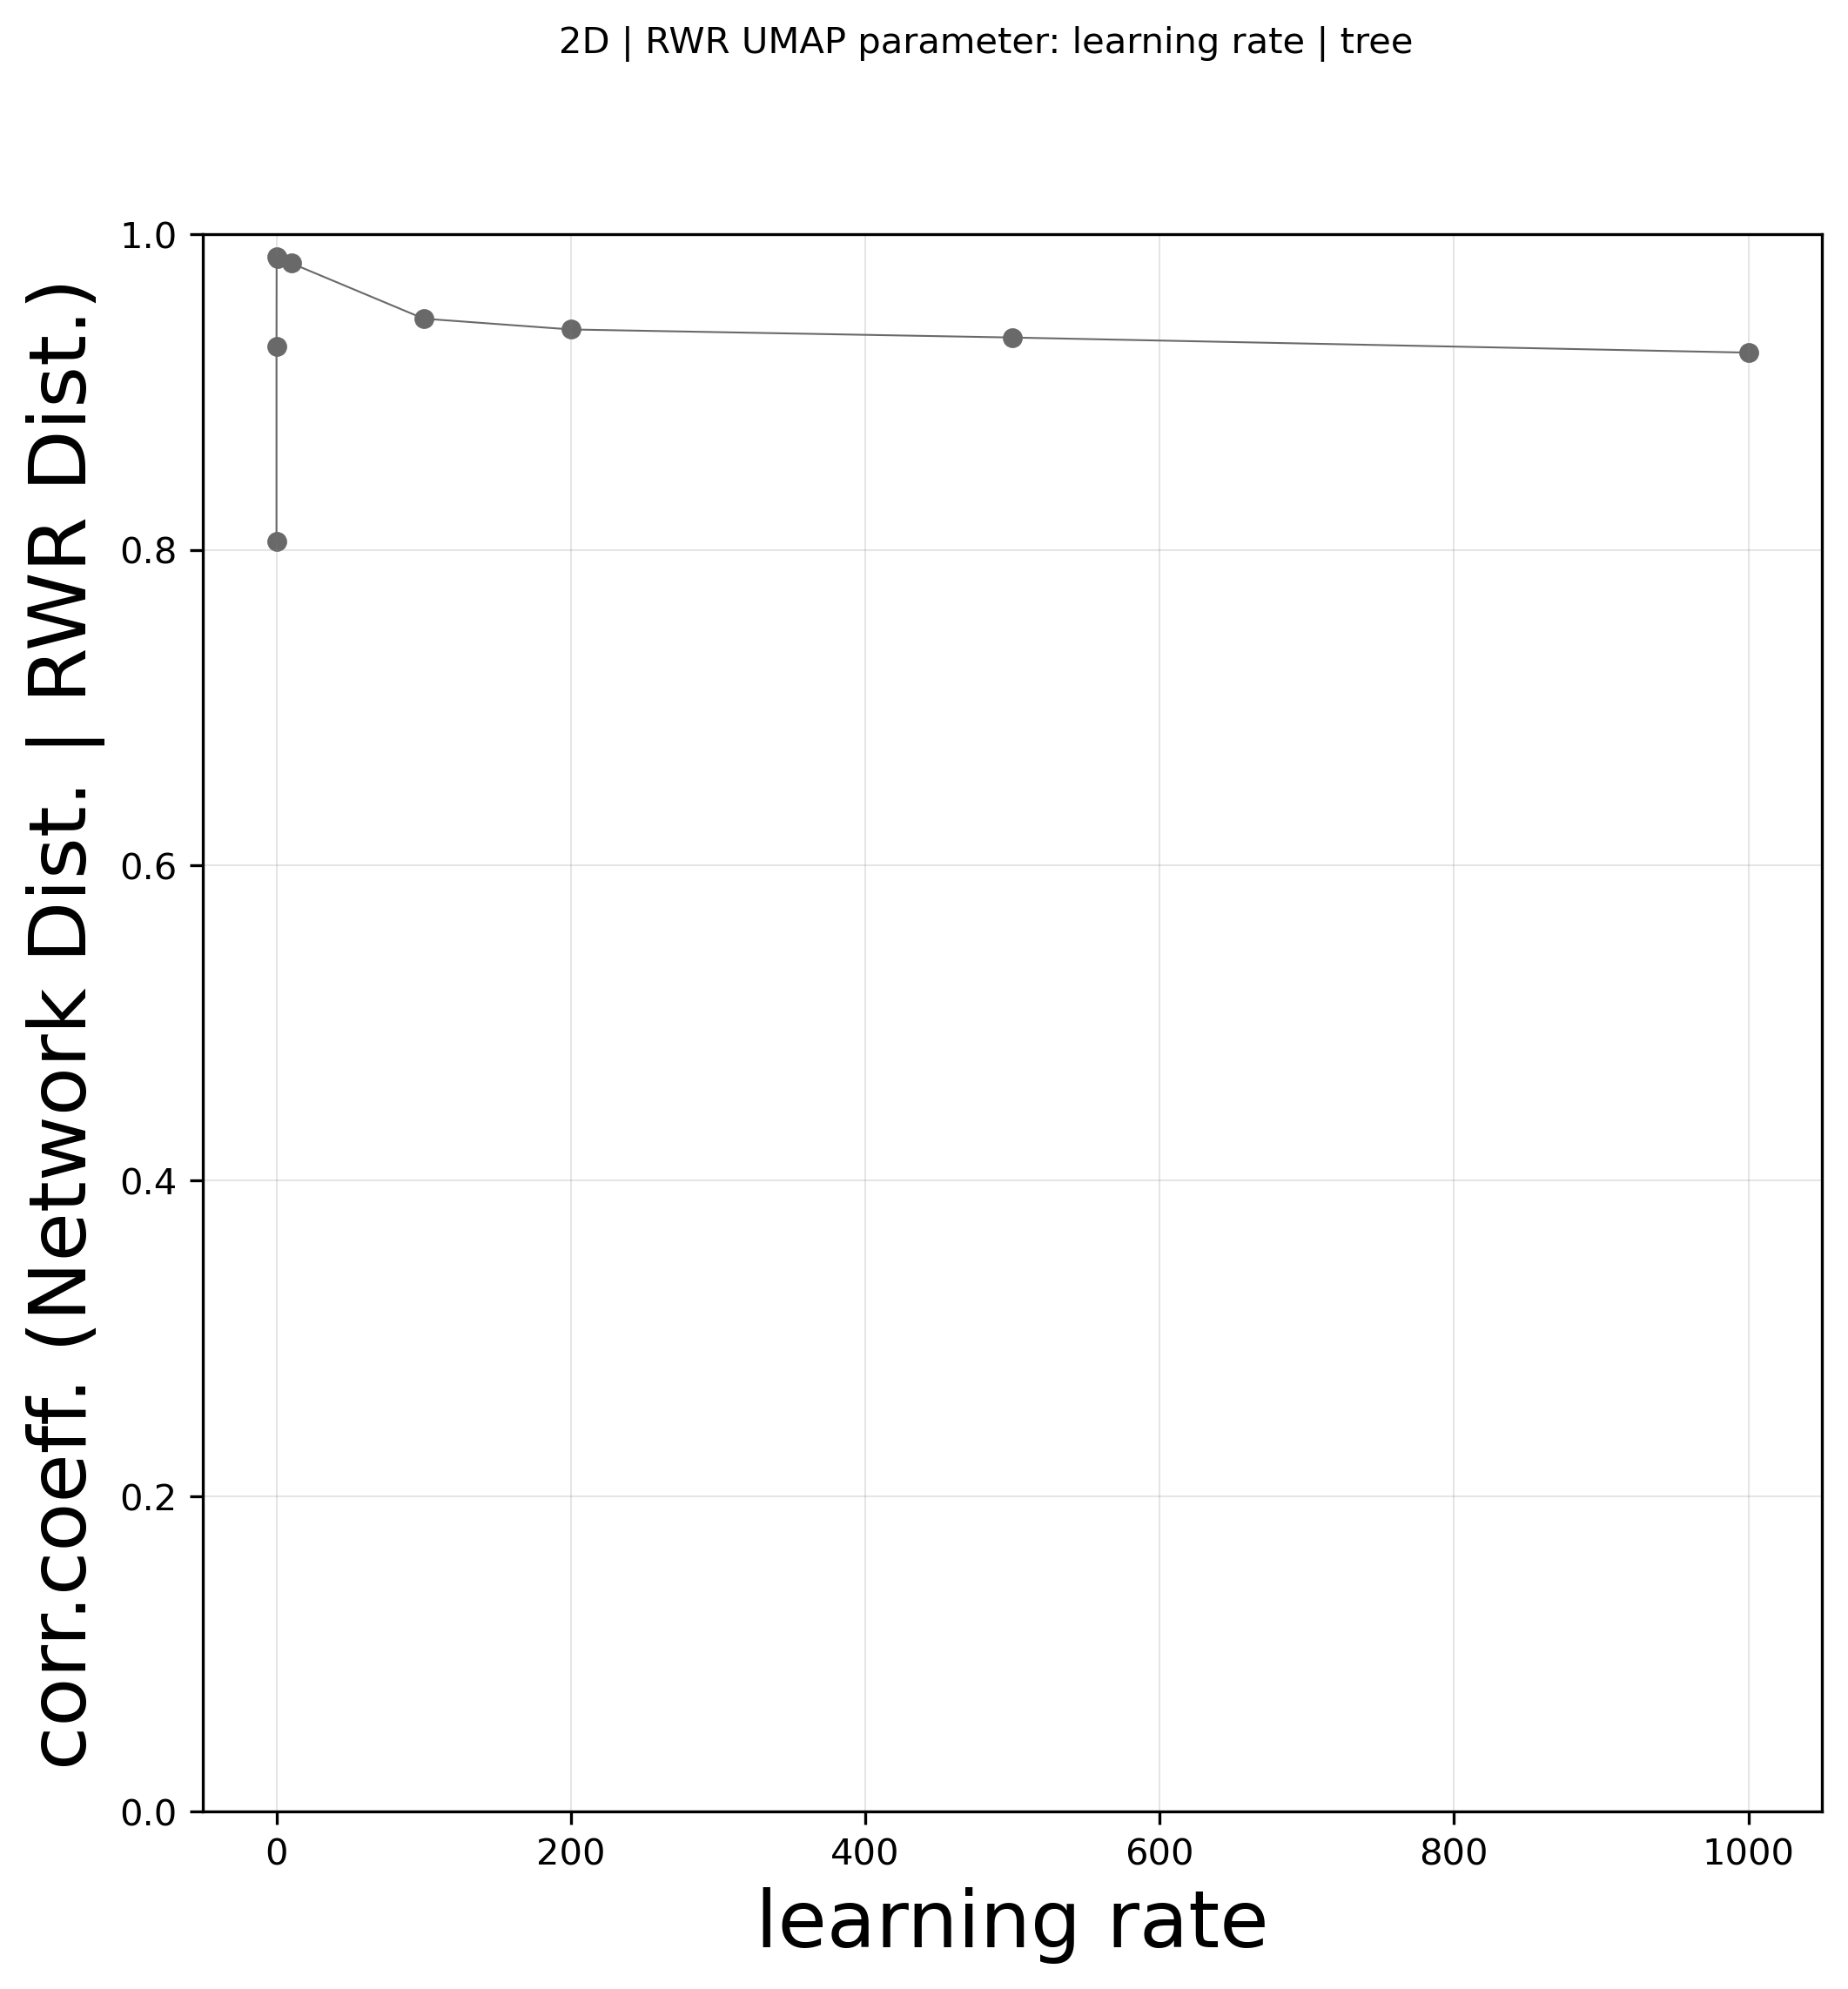

In [52]:
x = list(d_rwr_lnr.keys())
y = list(d_r_values_rwr_lnr.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.suptitle('2D | RWR UMAP parameter: learning rate | '+organism, fontsize=10)
plt.xlabel("learning rate", fontsize=22)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=22)
plt.ylim(ymin=0, ymax=1.0)
plt.grid(True, c='grey', alpha=0.2, linewidth=0.5)

plt.plot(x,y, '-', c = 'dimgrey', linewidth=0.5, alpha = 1.0)
plt.scatter(x,y, c = 'dimgrey', s = 20, alpha = 1.0)

fig.savefig('output_plots/benchmark/Correlation_learnrate_'+feature+'_'+organism+'.png')

In [ ]:
# CAYLEY TREE 
# parameters after testing 

n_neighbors = 12
spread = 6
min_dist = 0.5
metric = 'cosine'
lnr = 0.1
nep = 200

_________

# EVALUATION - 3D


In [55]:
################################################
#
# C U B E G R I D
#
################################################

organism = 'grid'

G = nx.grid_graph([10,10,10],periodic=False)


# NETWORK DISTANCE

dist_network = {}
for a in nx.shortest_path_length(G):
    for n,spl in a[1].items():
        dist_network[(a[0],n)] = spl

In [79]:
################################################
#
# T O R U S L A T T I C E 
#
################################################

organism = 'torus'

G = nx.grid_2d_graph(44,22,periodic=True)


# NETWORK DISTANCE

dist_network = {}
for a in nx.shortest_path_length(G):
    for n,spl in a[1].items():
        dist_network[(a[0],n)] = spl

### CURRENT NETWORK 

In [80]:
print('Network:', organism)
print('Number of nodes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
print('Network density: %.11f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Network: torus
Number of nodes: 968
Number of edges: 1936
Network density: 0.41322358149%


### UMAP - RWR

### Impact of UMAP PARAMETERS to CORRELATION COEFFICIENT (of Network Dist / Layout Dist) 
+ number of neighbors 
+ n_epochs
+ learning rate 
+ spread 
+ min_dist

In [81]:
feature = 'RWRvis'

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 20 
spread = 1
min_dist = 0.0 
metric ='cosine'
lnr = 1 
nep = None

r = 0.9
a = 1

#### ------ NUMBER OF NEIGHBORS ------
+ The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation
+ Larger values result in more global views of the manifold, while smaller values result in more local data being preserved 
+ In general values should be in the range 2 to 100.

In [82]:
# NUMBER OF NEIGHBORS 

n_neighbor_list = [4,8,12,16,20,50,100,200]

d_rwr_neigh = {}
d_r_values_rwr_neigh = {}

for i in n_neighbor_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m.T

    umap_rwr_3D = embed_umap_3D(DM_rwr, i, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)

    posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
    posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

    df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    end = time.time()
    
    print('UMAP n_neighs:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_neigh[i] = walltime_rwr
    
    posG=posG_3D_complete_umap_rwr_norm
    dist_layout3D = {} 
    for p1,p2 in it.combinations(G.nodes(),2):
        dist_layout3D[(p1,p2)] = np.sqrt((posG[p1][0]-posG[p2][0])**2+(posG[p1][1]-posG[p2][1])**2+(posG[p1][2]-posG[p2][2])**2)

    dist_network_mod = {}
    for j,m in dist_network.items():
        if j in dist_layout3D.keys():
            dist_network_mod[j]=float(m)

    d_plot_layout = {}
    for spldist in range(1,int(max(dist_network_mod.values()))+1):
        l_s = []
        for k, v in dist_network_mod.items():
            if v == spldist:
                l_s.append(k)
        l_xy = []
        for nodes in l_s:
            dxy = dist_layout3D[nodes]
            l_xy.append(dxy)
        d_plot_layout[spldist] = l_xy

    l_medians_layout = []
    for k, v in d_plot_layout.items():
        l_medians_layout.append(statistics.median(v))

    x = np.array(range(1,int(max(dist_network_mod.values()))+1))
    y = np.array(l_medians_layout)
    r_layout = np.corrcoef(x, y)

    print('GLOBAL (RWR) Pearson Correlation Factor: ', r_layout[0][1])

    d_r_values_rwr_neigh[i] = r_layout[0][1]

UMAP n_neighs: 4
Execution Time: 00:00:20
min: 0 sec: 20
GLOBAL (RWR) Pearson Correlation Factor:  0.9733282471476488
UMAP n_neighs: 8
Execution Time: 00:00:16
min: 0 sec: 16
GLOBAL (RWR) Pearson Correlation Factor:  0.951325831250992
UMAP n_neighs: 12
Execution Time: 00:00:16
min: 0 sec: 16
GLOBAL (RWR) Pearson Correlation Factor:  0.9732958515494182
UMAP n_neighs: 16
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9642536902014089
UMAP n_neighs: 20
Execution Time: 00:00:15
min: 0 sec: 15
GLOBAL (RWR) Pearson Correlation Factor:  0.9781397041596264
UMAP n_neighs: 50
Execution Time: 00:00:15
min: 0 sec: 15
GLOBAL (RWR) Pearson Correlation Factor:  0.972250701475802
UMAP n_neighs: 100
Execution Time: 00:00:16
min: 0 sec: 16
GLOBAL (RWR) Pearson Correlation Factor:  0.974069880858405
UMAP n_neighs: 200
Execution Time: 00:00:16
min: 0 sec: 16
GLOBAL (RWR) Pearson Correlation Factor:  0.965851991467729


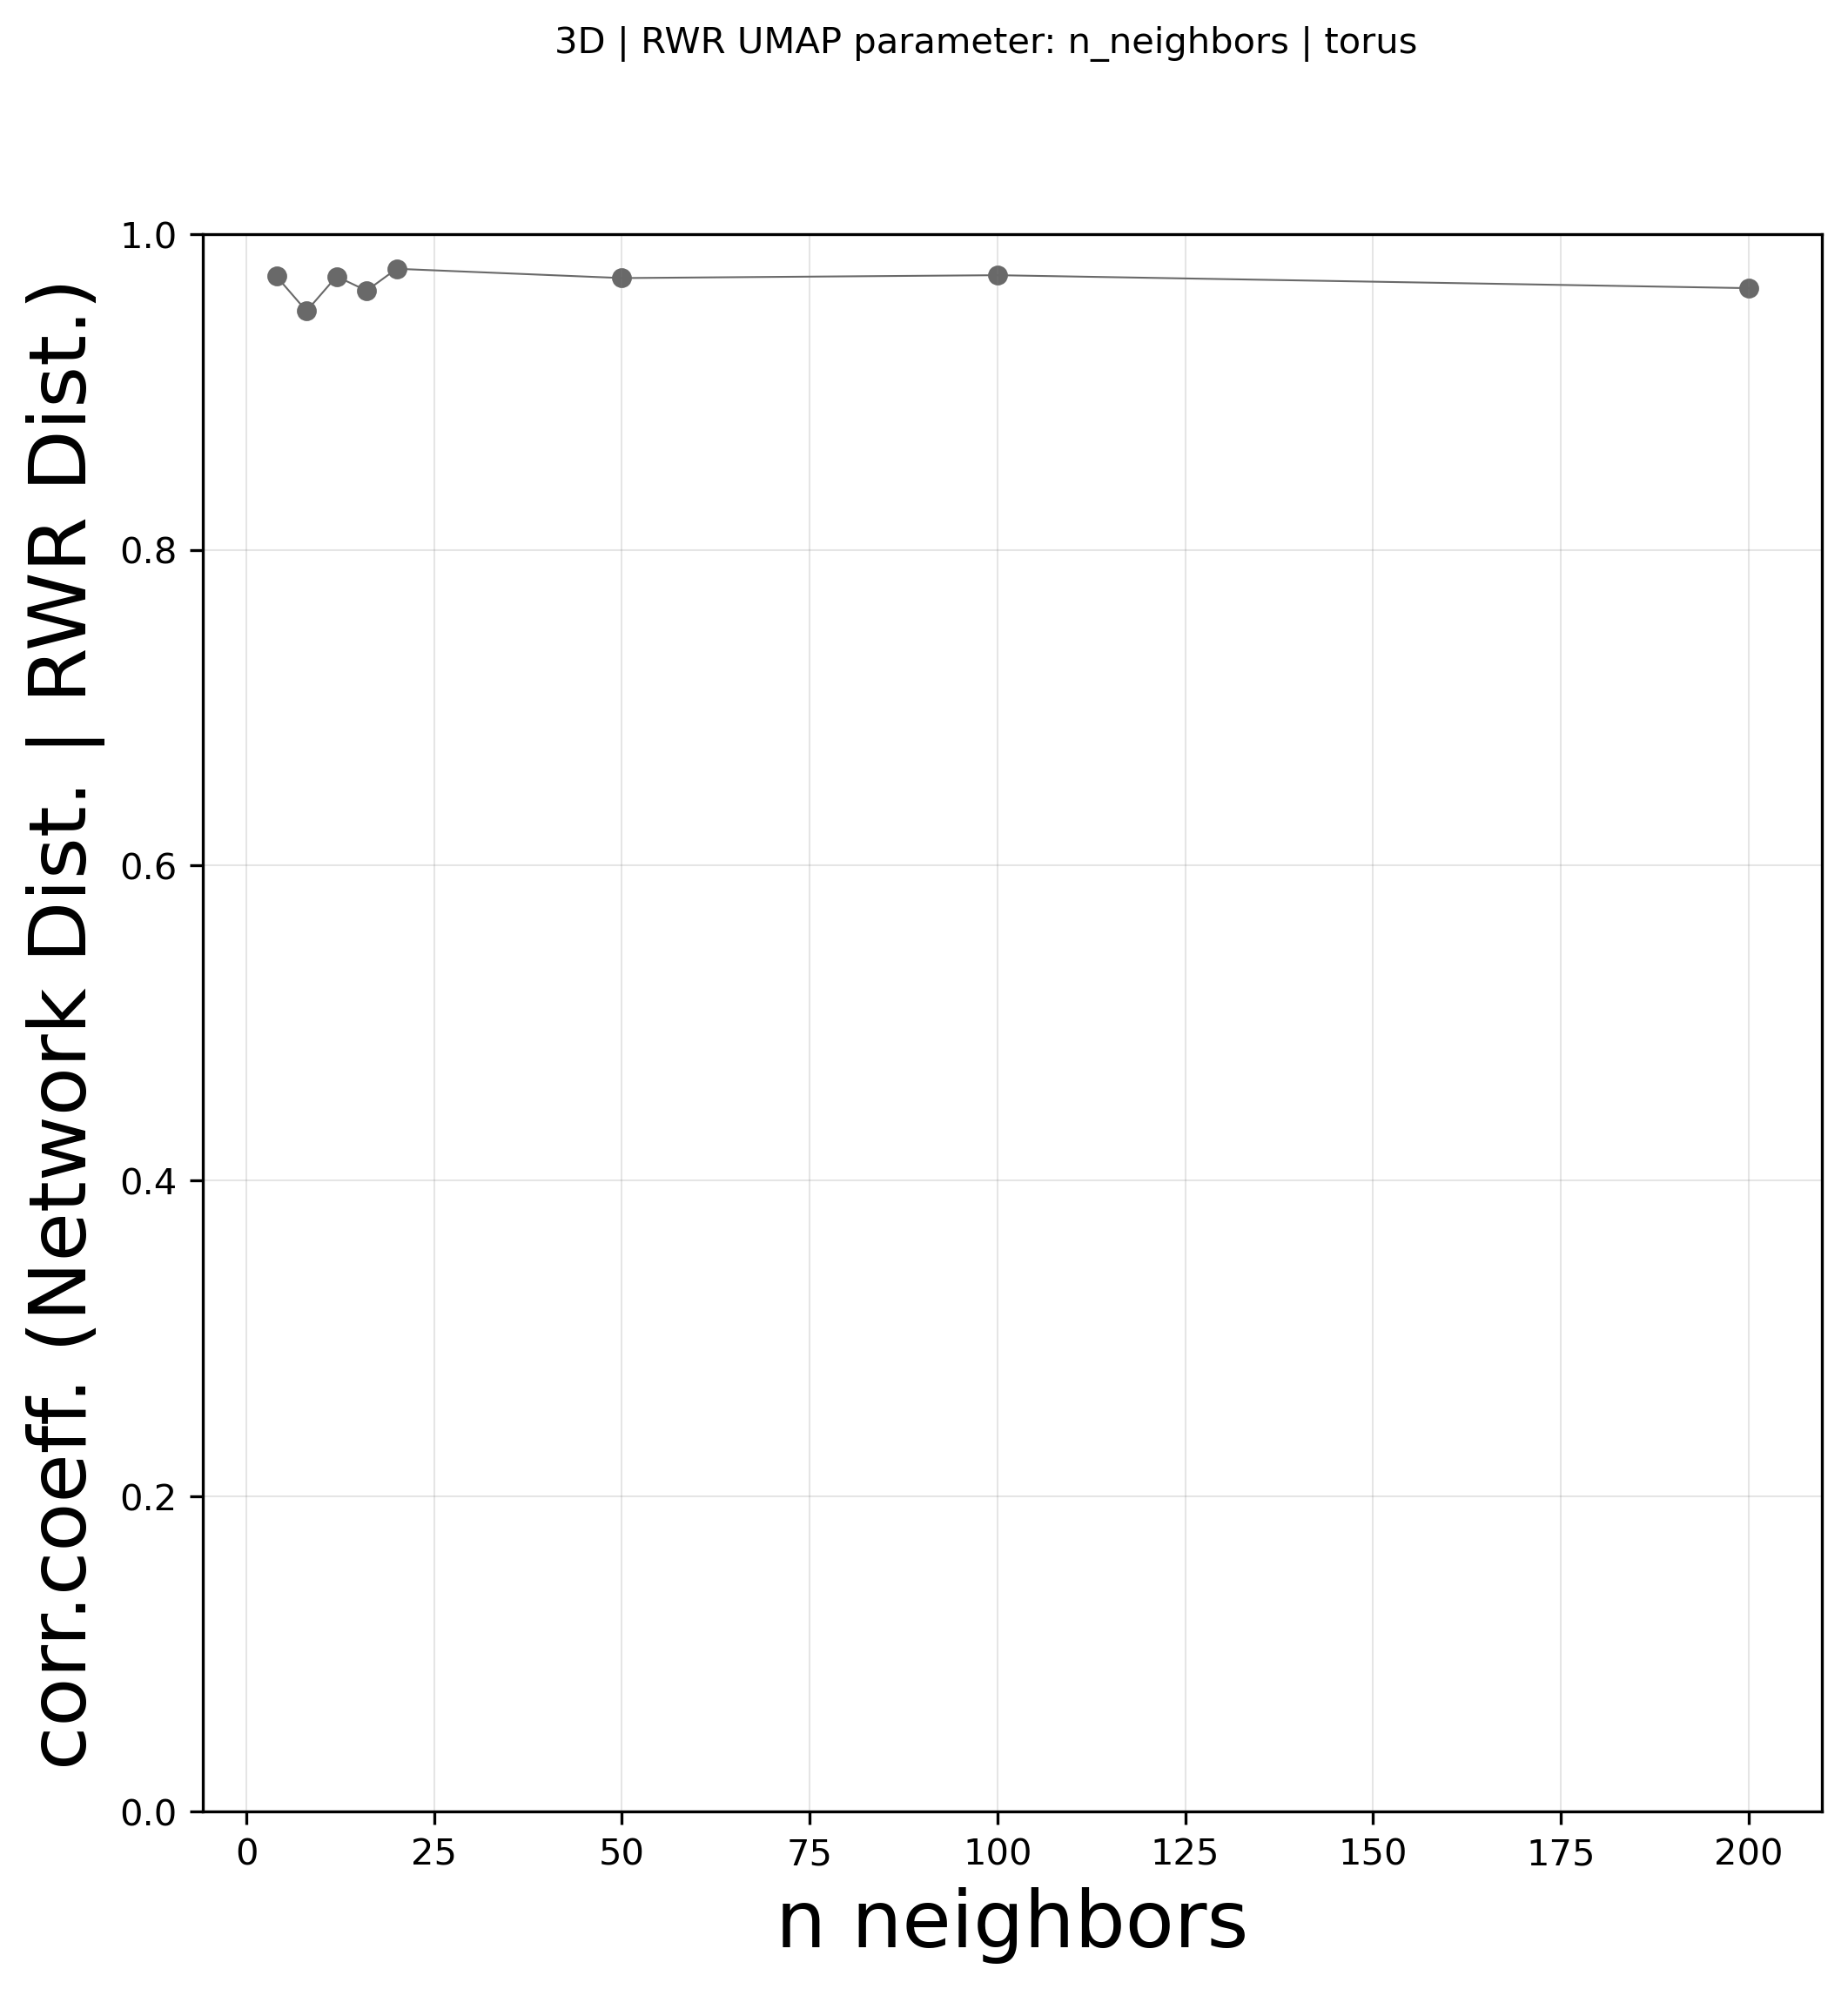

In [83]:
x = list(d_rwr_neigh.keys())
y = list(d_r_values_rwr_neigh.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.suptitle('3D | RWR UMAP parameter: n_neighbors | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

plt.xlabel("n neighbors", fontsize = 22)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize = 22)
plt.grid(True, c='grey', alpha=0.2, linewidth=0.5)

plt.plot(x,y, '-', c = 'dimgrey', linewidth=0.5, alpha = 1.0)
plt.scatter(x,y, c = 'dimgrey', s = 20, alpha = 1.0)

fig.savefig('output_plots/benchmark/Correlation3D_neighs_'+feature+'_'+organism+'.png')

In [86]:
#adjust parameters 

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 20
spread = 1.0
min_dist = 0.0
metric ='cosine'
lnr = 1
nep = None

#### ------ MIN DIST ------
+ The effective minimum distance between embedded points
+ Smaller values will result in a more clustered/clumped embedding where nearby points on the manifold are drawn closer together, while larger values will result on a more even dispersal of points

In [87]:
# MIN DIST 

mindist_list = [0.001,0.01,0.1,0.5,0.9,1]

d_rwr_mdist = {}
d_r_values_rwr_mdist = {}

for i in mindist_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m.T

    umap_rwr_3D = embed_umap_3D(DM_rwr, n_neighbors, spread, i, metric, learn_rate = lnr, n_ep = nep)

    posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
    posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

    df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    end = time.time()
    
    print('UMAP min dist:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_mdist[i] = walltime_rwr
    
    posG=posG_3D_complete_umap_rwr_norm
    dist_layout3D = {} 
    for p1,p2 in it.combinations(G.nodes(),2):
        dist_layout3D[(p1,p2)] = np.sqrt((posG[p1][0]-posG[p2][0])**2+(posG[p1][1]-posG[p2][1])**2+(posG[p1][2]-posG[p2][2])**2)

    dist_network_mod = {}
    for j,m in dist_network.items():
        if j in dist_layout3D.keys():
            dist_network_mod[j]=float(m)

    d_plot_layout = {}
    for spldist in range(1,int(max(dist_network_mod.values()))+1):
        l_s = []
        for k, v in dist_network_mod.items():
            if v == spldist:
                l_s.append(k)
        l_xy = []
        for nodes in l_s:
            dxy = dist_layout3D[nodes]
            l_xy.append(dxy)
        d_plot_layout[spldist] = l_xy

    l_medians_layout = []
    for k, v in d_plot_layout.items():
        l_medians_layout.append(statistics.median(v))

    x = np.array(range(1,int(max(dist_network_mod.values()))+1))
    y = np.array(l_medians_layout)
    r_layout = np.corrcoef(x, y)

    print('GLOBAL (RWR) Pearson Correlation Factor: ', r_layout[0][1])

    d_r_values_rwr_mdist[i] = r_layout[0][1]

UMAP min dist: 0.001
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9740317938296115
UMAP min dist: 0.01
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9778089620109134
UMAP min dist: 0.1
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9794479715800848
UMAP min dist: 0.5
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9555133537615952
UMAP min dist: 0.9
Execution Time: 00:00:15
min: 0 sec: 15
GLOBAL (RWR) Pearson Correlation Factor:  0.9758318111395811
UMAP min dist: 1
Execution Time: 00:00:16
min: 0 sec: 16
GLOBAL (RWR) Pearson Correlation Factor:  0.9792006909679539


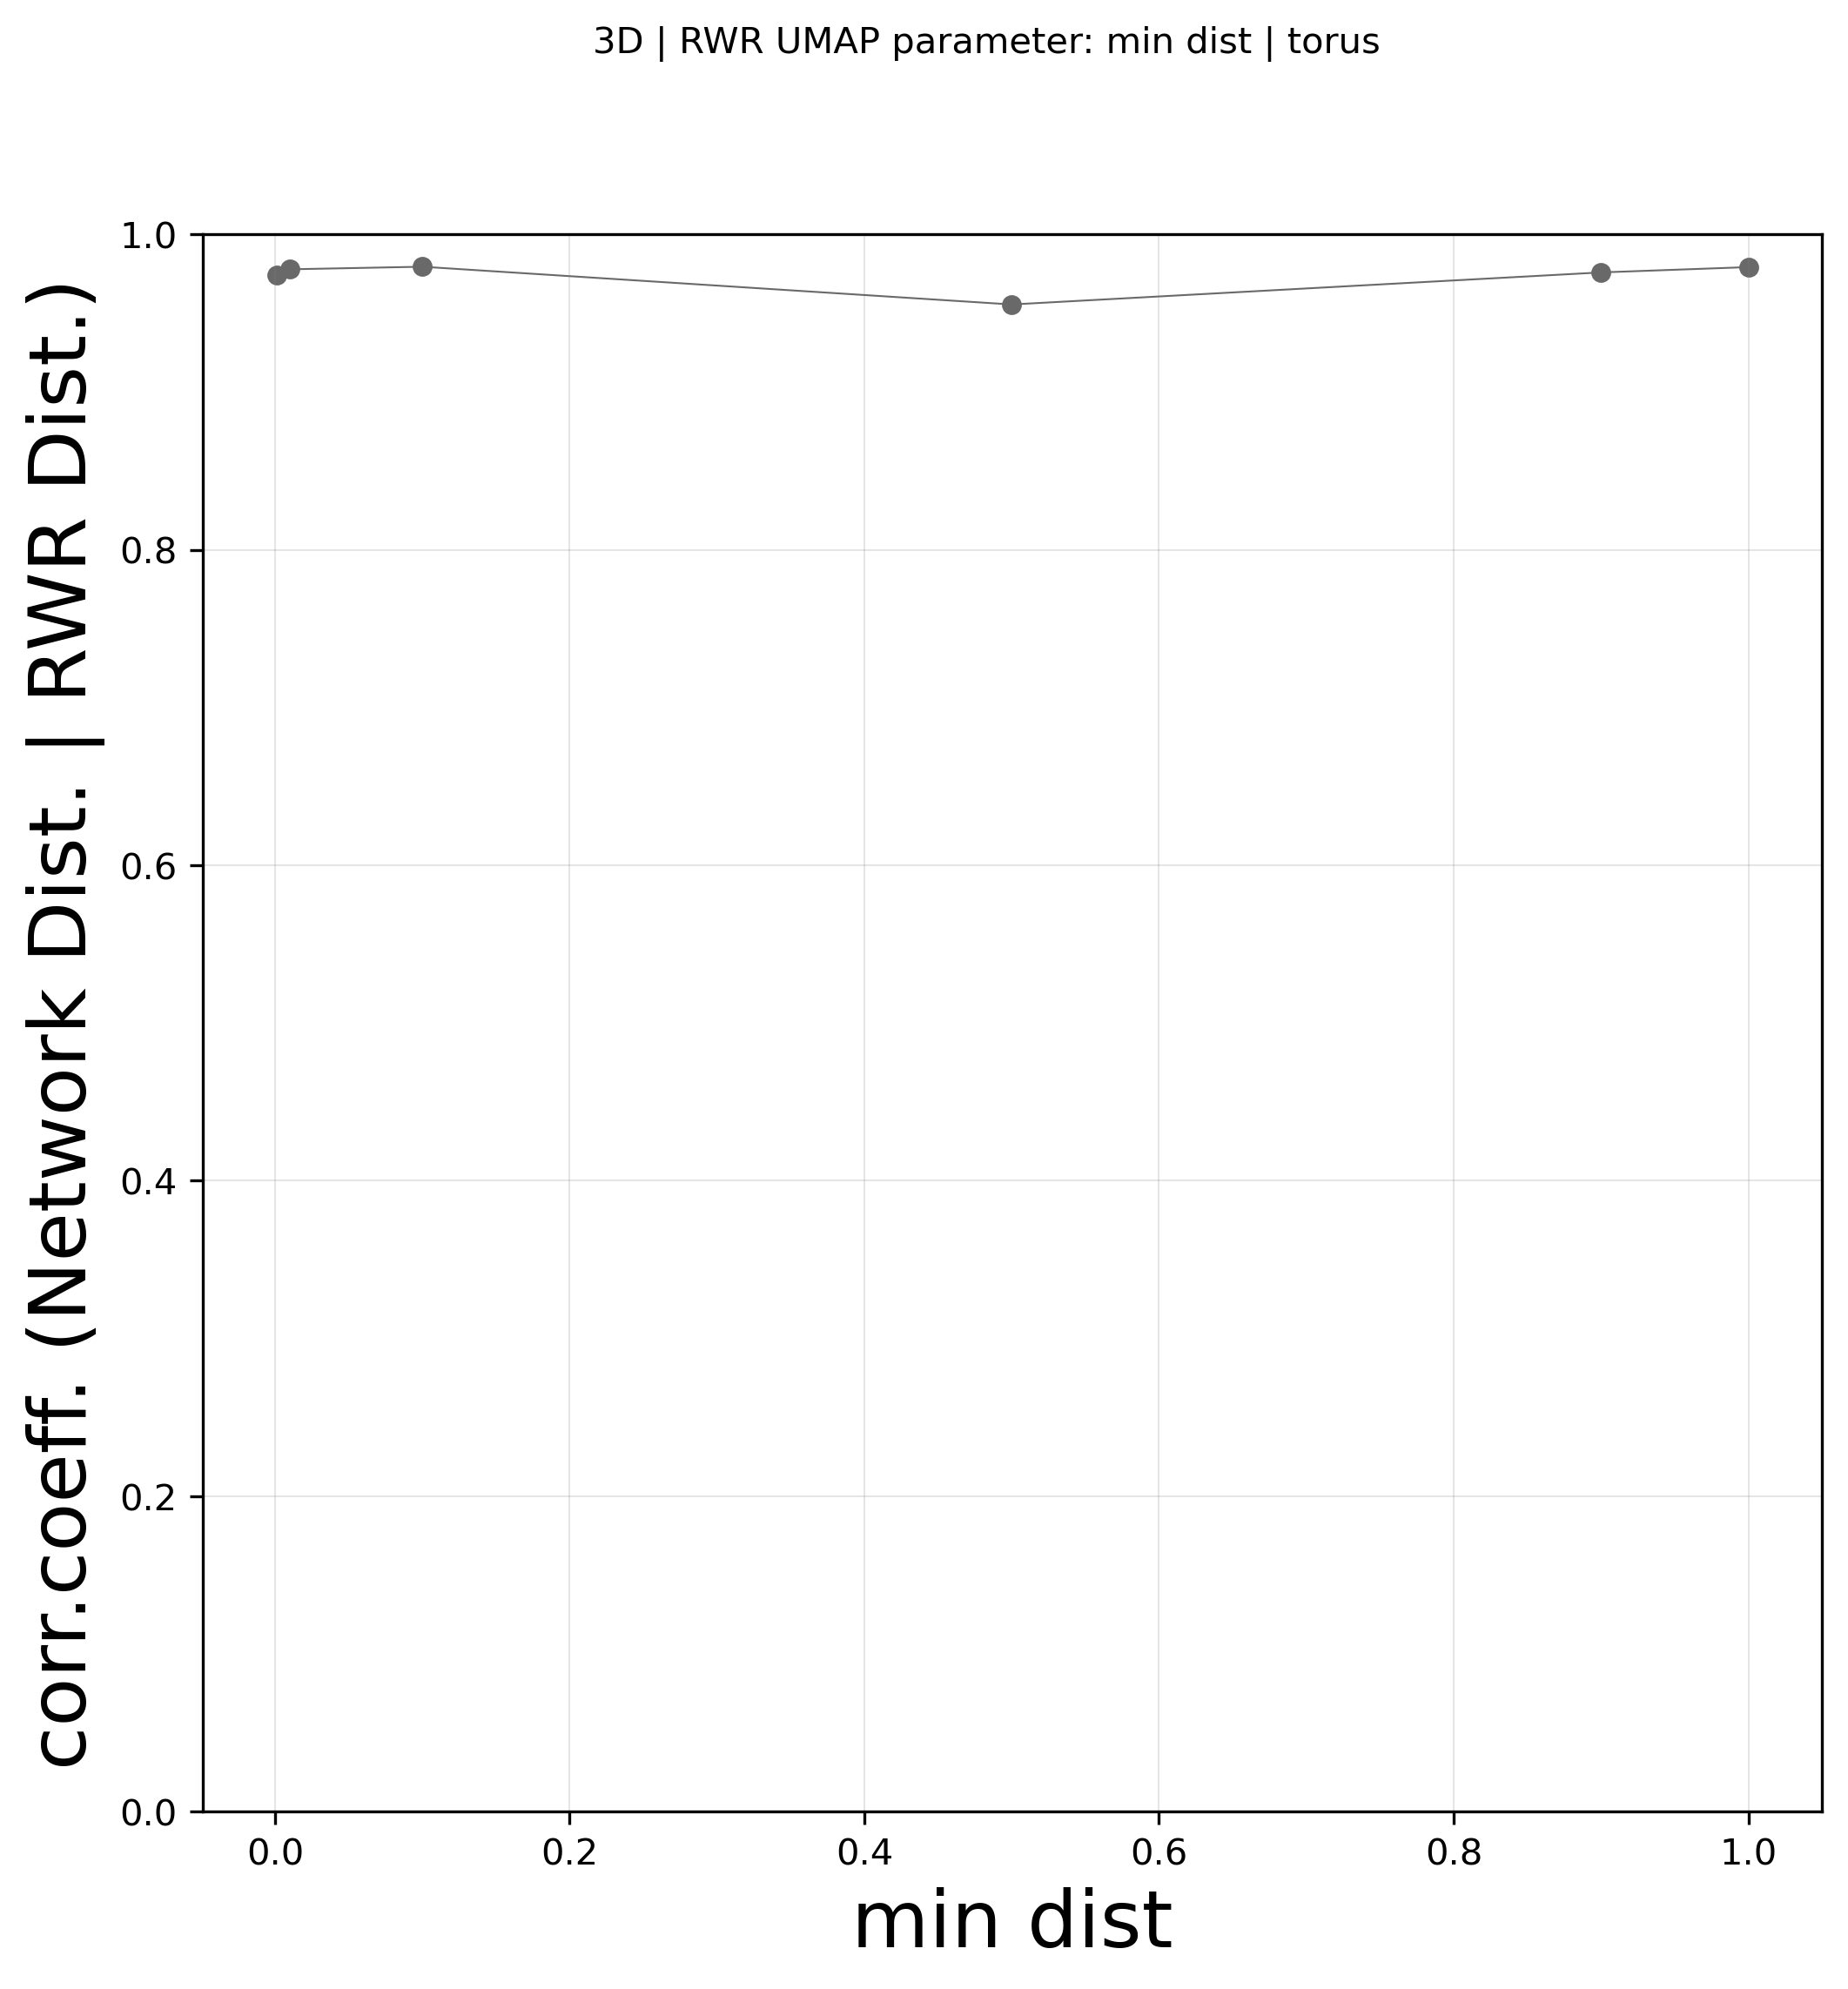

In [88]:
x = list(d_rwr_mdist.keys())
y = list(d_r_values_rwr_mdist.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.suptitle('3D | RWR UMAP parameter: min dist | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

plt.xlabel("min dist", fontsize = 22)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize = 22)
plt.grid(True, c='grey', alpha=0.2, linewidth=0.5)

plt.plot(x,y, '-', c = 'dimgrey', linewidth=0.5, alpha = 1.0)
plt.scatter(x,y, c = 'dimgrey', s = 20, alpha = 1.0)

fig.savefig('output_plots/benchmark/Correlation3D_mindist_'+feature+'_'+organism+'.png')

In [89]:
#adjust parameters 

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 20
spread = 1
min_dist = 0.1
metric = 'cosine'
lnr = 1
nep = None

#### ------ SPREAD ------
+ The effective scale of embedded points
+ In combination with min_dist this determines how clustered/clumped the embedded points are

In [90]:
# SPREAD

spread_list = [0.9,1,2,3,4,5,6,7,8,9,10]

d_rwr_spread = {}
d_r_values_rwr_spread  = {}

for i in spread_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m.T

    umap_rwr_3D = embed_umap_3D(DM_rwr, n_neighbors, i, min_dist, metric, learn_rate = lnr, n_ep = nep)

    posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
    posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

    df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    end = time.time()
    
    print('UMAP spread:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_spread[i] = walltime_rwr
    
    posG=posG_3D_complete_umap_rwr_norm
    dist_layout3D = {} 
    for p1,p2 in it.combinations(G.nodes(),2):
        dist_layout3D[(p1,p2)] = np.sqrt((posG[p1][0]-posG[p2][0])**2+(posG[p1][1]-posG[p2][1])**2+(posG[p1][2]-posG[p2][2])**2)

    dist_network_mod = {}
    for j,m in dist_network.items():
        if j in dist_layout3D.keys():
            dist_network_mod[j]=float(m)

    d_plot_layout = {}
    for spldist in range(1,int(max(dist_network_mod.values()))+1):
        l_s = []
        for k, v in dist_network_mod.items():
            if v == spldist:
                l_s.append(k)
        l_xy = []
        for nodes in l_s:
            dxy = dist_layout3D[nodes]
            l_xy.append(dxy)
        d_plot_layout[spldist] = l_xy

    l_medians_layout = []
    for k, v in d_plot_layout.items():
        l_medians_layout.append(statistics.median(v))

    x = np.array(range(1,int(max(dist_network_mod.values()))+1))
    y = np.array(l_medians_layout)
    r_layout = np.corrcoef(x, y)

    print('GLOBAL (RWR) Pearson Correlation Factor: ', r_layout[0][1])

    d_r_values_rwr_spread[i] = r_layout[0][1]

UMAP spread: 0.9
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9525570874938607
UMAP spread: 1
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9794479715800848
UMAP spread: 2
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.966761660429087
UMAP spread: 3
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9745805826076832


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 4
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9778289187951718


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 5
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9783335681382285


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 6
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9791942164237558


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 7
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9785048475801837


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 8
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9786980632813315


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 9
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9785884271566774


/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



UMAP spread: 10
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9782723783220928


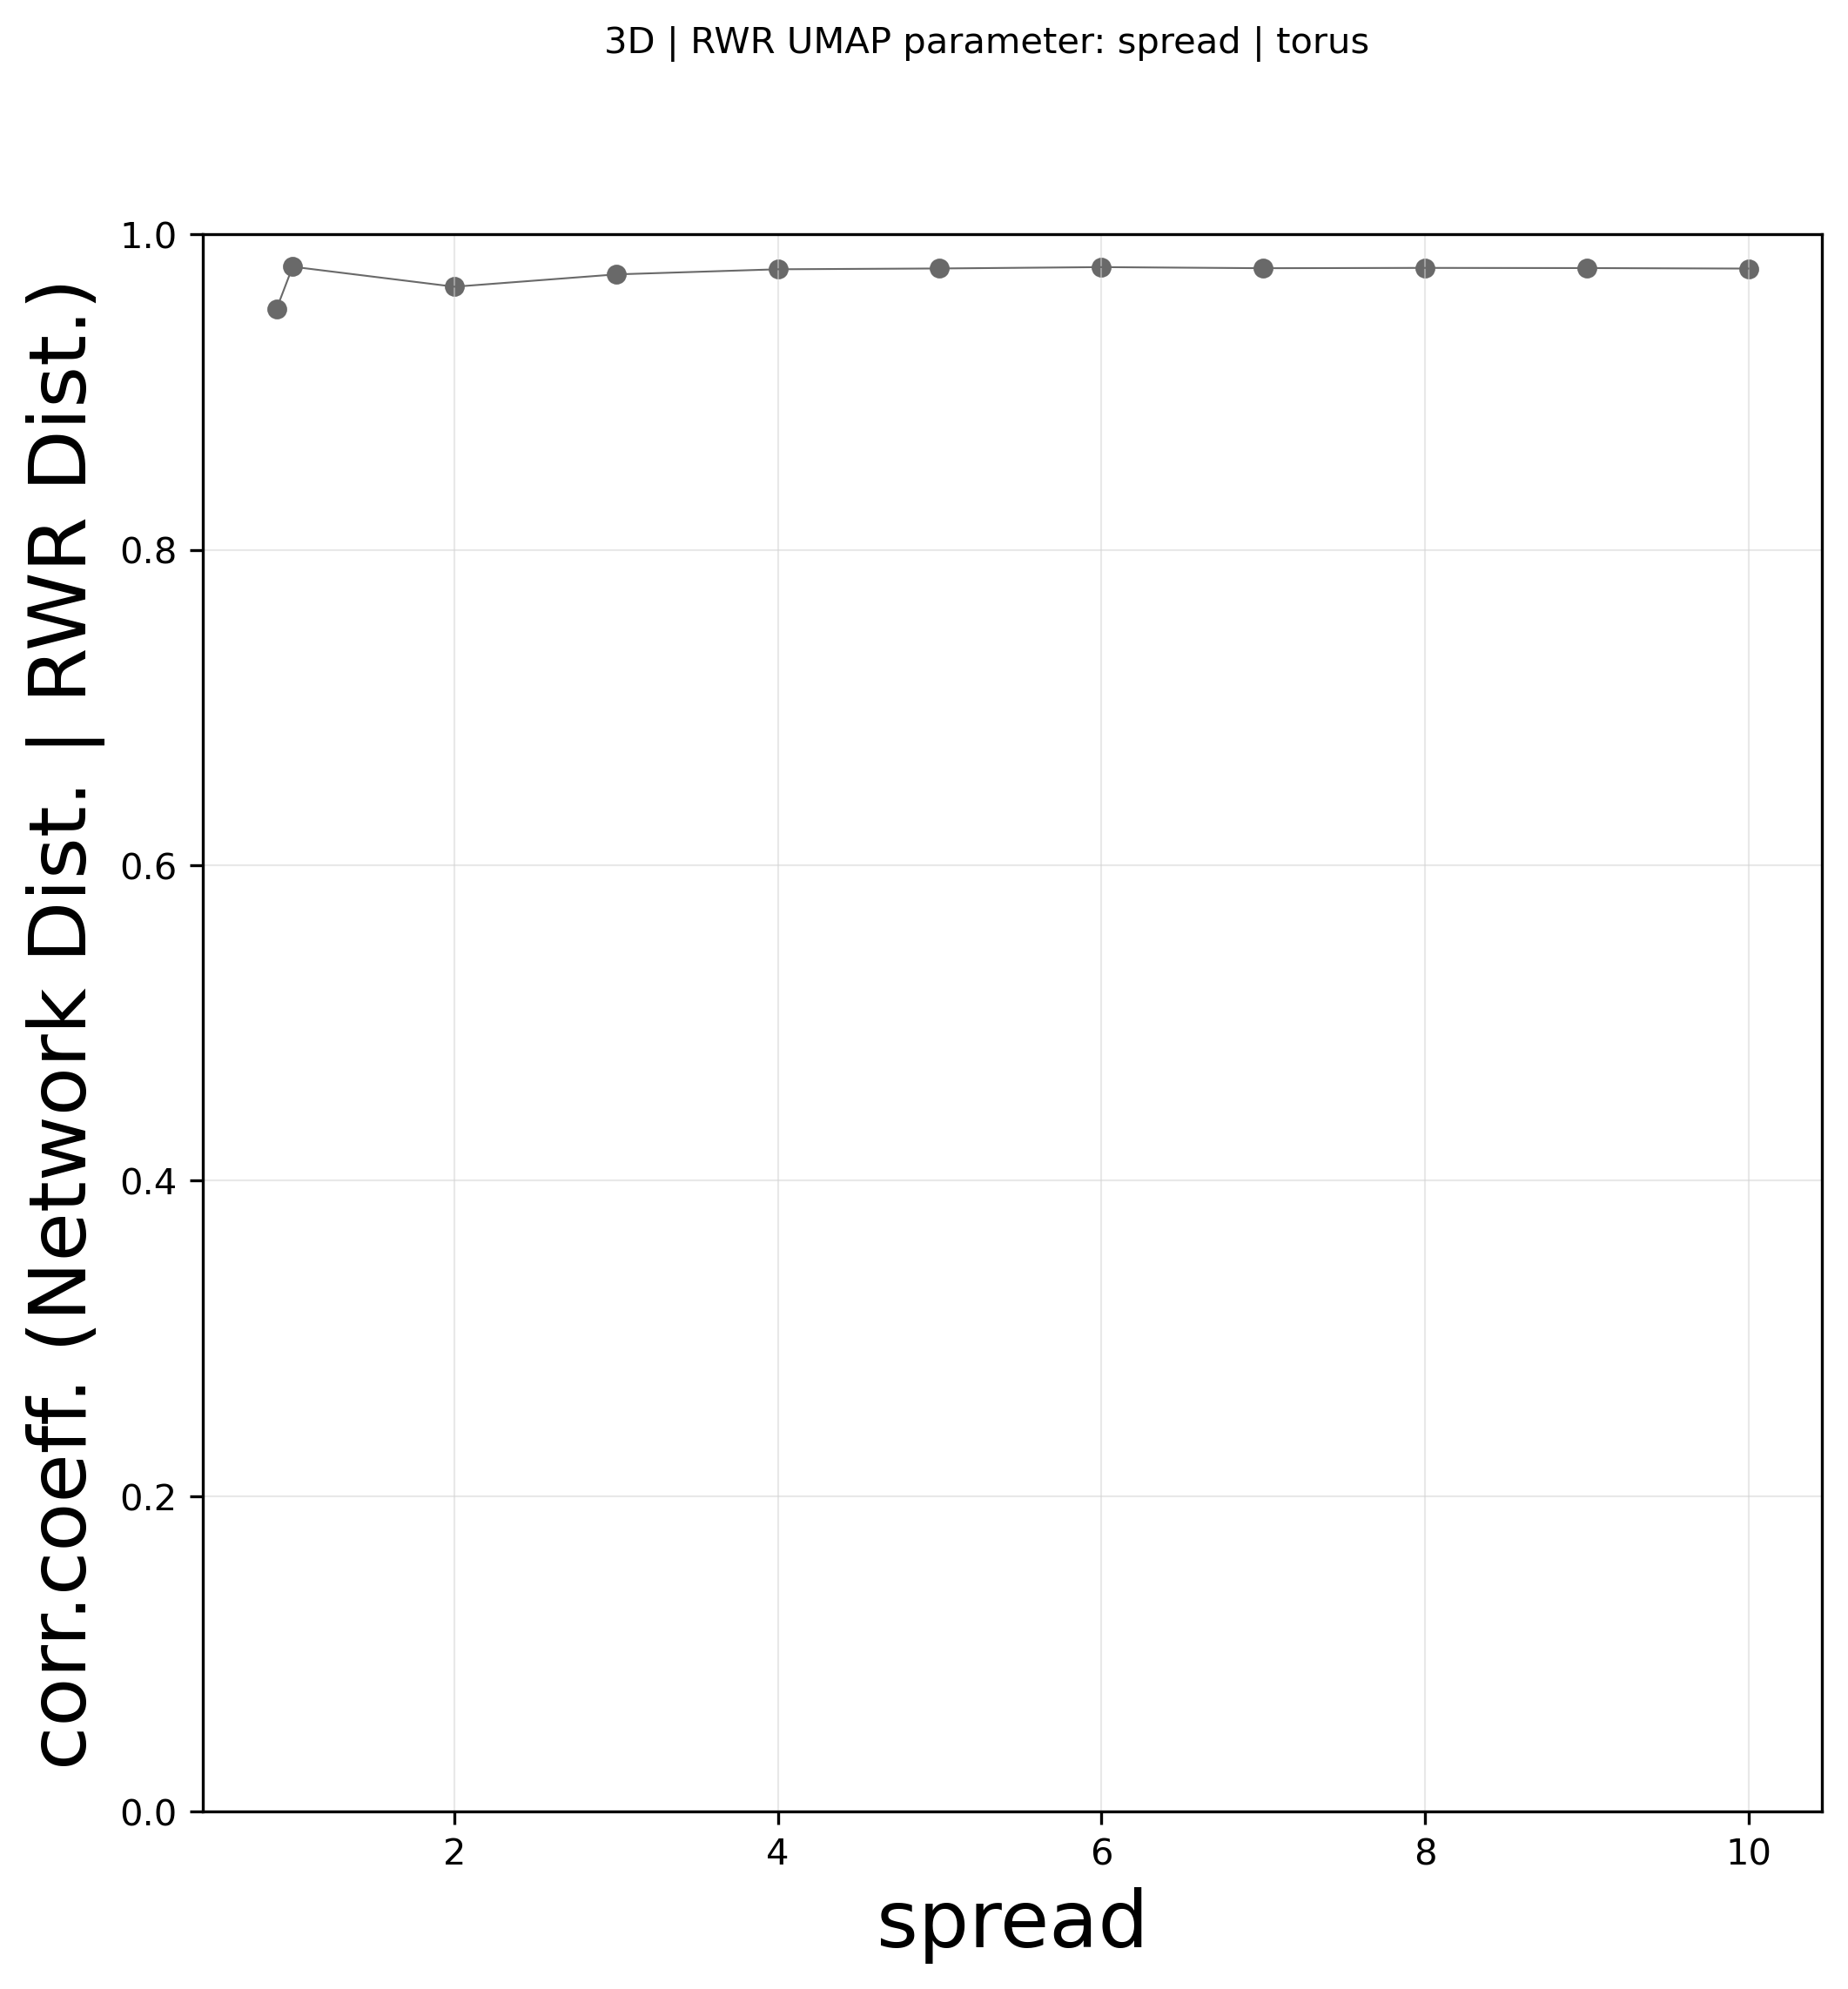

In [91]:
x = list(d_rwr_spread.keys())
y = list(d_r_values_rwr_spread.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.ylim(ymin=0, ymax=1.0)
plt.xlabel("spread", fontsize=22)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=22)
plt.grid(True, c='grey', alpha=0.2, linewidth=0.5)

plt.plot(x,y, '-', c = 'dimgrey', linewidth=0.5, alpha = 1.0)
plt.scatter(x,y, c = 'dimgrey', s = 20, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('3D | RWR UMAP parameter: spread | '+organism, fontsize=10)

fig.savefig('output_plots/benchmark/Correlation3D_spread_'+feature+'_'+organism+'.png')

In [92]:
#adjust parameters 

#-----------------------------
# UMAP PARAMETERS:
#-----------------------------
n_neighbors = 20
spread = 1
min_dist = 0.1
metric = 'cosine'
lnr = 1
nep = None

#### ------ NUMBER OF EPOCHS ------
+ The number of training epochs to be used in optimizing the low dimensional embedding
+ Larger values result in more accurate embeddings 
+ If None is specified a value will be selected based on the size of the input dataset (200 for large datasets, 500 for small)

In [93]:
# NUMBER OF EPOCHS 

nep_list = [None, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

d_rwr_epochs = {}
d_r_values_rwr_nep = {}

for i in nep_list: 
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m.T

    umap_rwr_3D = embed_umap_3D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = i)

    posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
    posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

    df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    end = time.time()

    print('UMAP n_epoch:' ,i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_epochs[i] = walltime_rwr

    posG=posG_3D_complete_umap_rwr_norm
    dist_layout3D = {} 
    for p1,p2 in it.combinations(G.nodes(),2):
        dist_layout3D[(p1,p2)] = np.sqrt((posG[p1][0]-posG[p2][0])**2+(posG[p1][1]-posG[p2][1])**2+(posG[p1][2]-posG[p2][2])**2)

    dist_network_mod = {}
    for j,m in dist_network.items():
        if j in dist_layout3D.keys():
            dist_network_mod[j]=float(m)

    d_plot_layout = {}
    for spldist in range(1,int(max(dist_network_mod.values()))+1):
        l_s = []
        for k, v in dist_network_mod.items():
            if v == spldist:
                l_s.append(k)
        l_xy = []
        for nodes in l_s:
            dxy = dist_layout3D[nodes]
            l_xy.append(dxy)
        d_plot_layout[spldist] = l_xy

    l_medians_layout = []
    for k, v in d_plot_layout.items():
        l_medians_layout.append(statistics.median(v))

    x = np.array(range(1,int(max(dist_network_mod.values()))+1))
    y = np.array(l_medians_layout)
    r_layout = np.corrcoef(x, y)
    
    print('GLOBAL (RWR) Pearson Correlation Factor: ', r_layout[0][1])

    d_r_values_rwr_nep[i] = r_layout[0][1]    

UMAP n_epoch: None
Execution Time: 00:00:15
min: 0 sec: 15
GLOBAL (RWR) Pearson Correlation Factor:  0.9794479715800848
UMAP n_epoch: 100
Execution Time: 00:00:13
min: 0 sec: 13
GLOBAL (RWR) Pearson Correlation Factor:  0.958828118656505
UMAP n_epoch: 200
Execution Time: 00:00:13
min: 0 sec: 13
GLOBAL (RWR) Pearson Correlation Factor:  0.9769614775864249
UMAP n_epoch: 300
Execution Time: 00:00:13
min: 0 sec: 13
GLOBAL (RWR) Pearson Correlation Factor:  0.9655126165379126
UMAP n_epoch: 400
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9773275916144699
UMAP n_epoch: 500
Execution Time: 00:00:15
min: 0 sec: 15
GLOBAL (RWR) Pearson Correlation Factor:  0.9794479715800848
UMAP n_epoch: 600
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9792491817291278
UMAP n_epoch: 700
Execution Time: 00:00:15
min: 0 sec: 15
GLOBAL (RWR) Pearson Correlation Factor:  0.9747901151842503
UMAP n_epoch: 800
Execution Time: 00:00:15
min: 

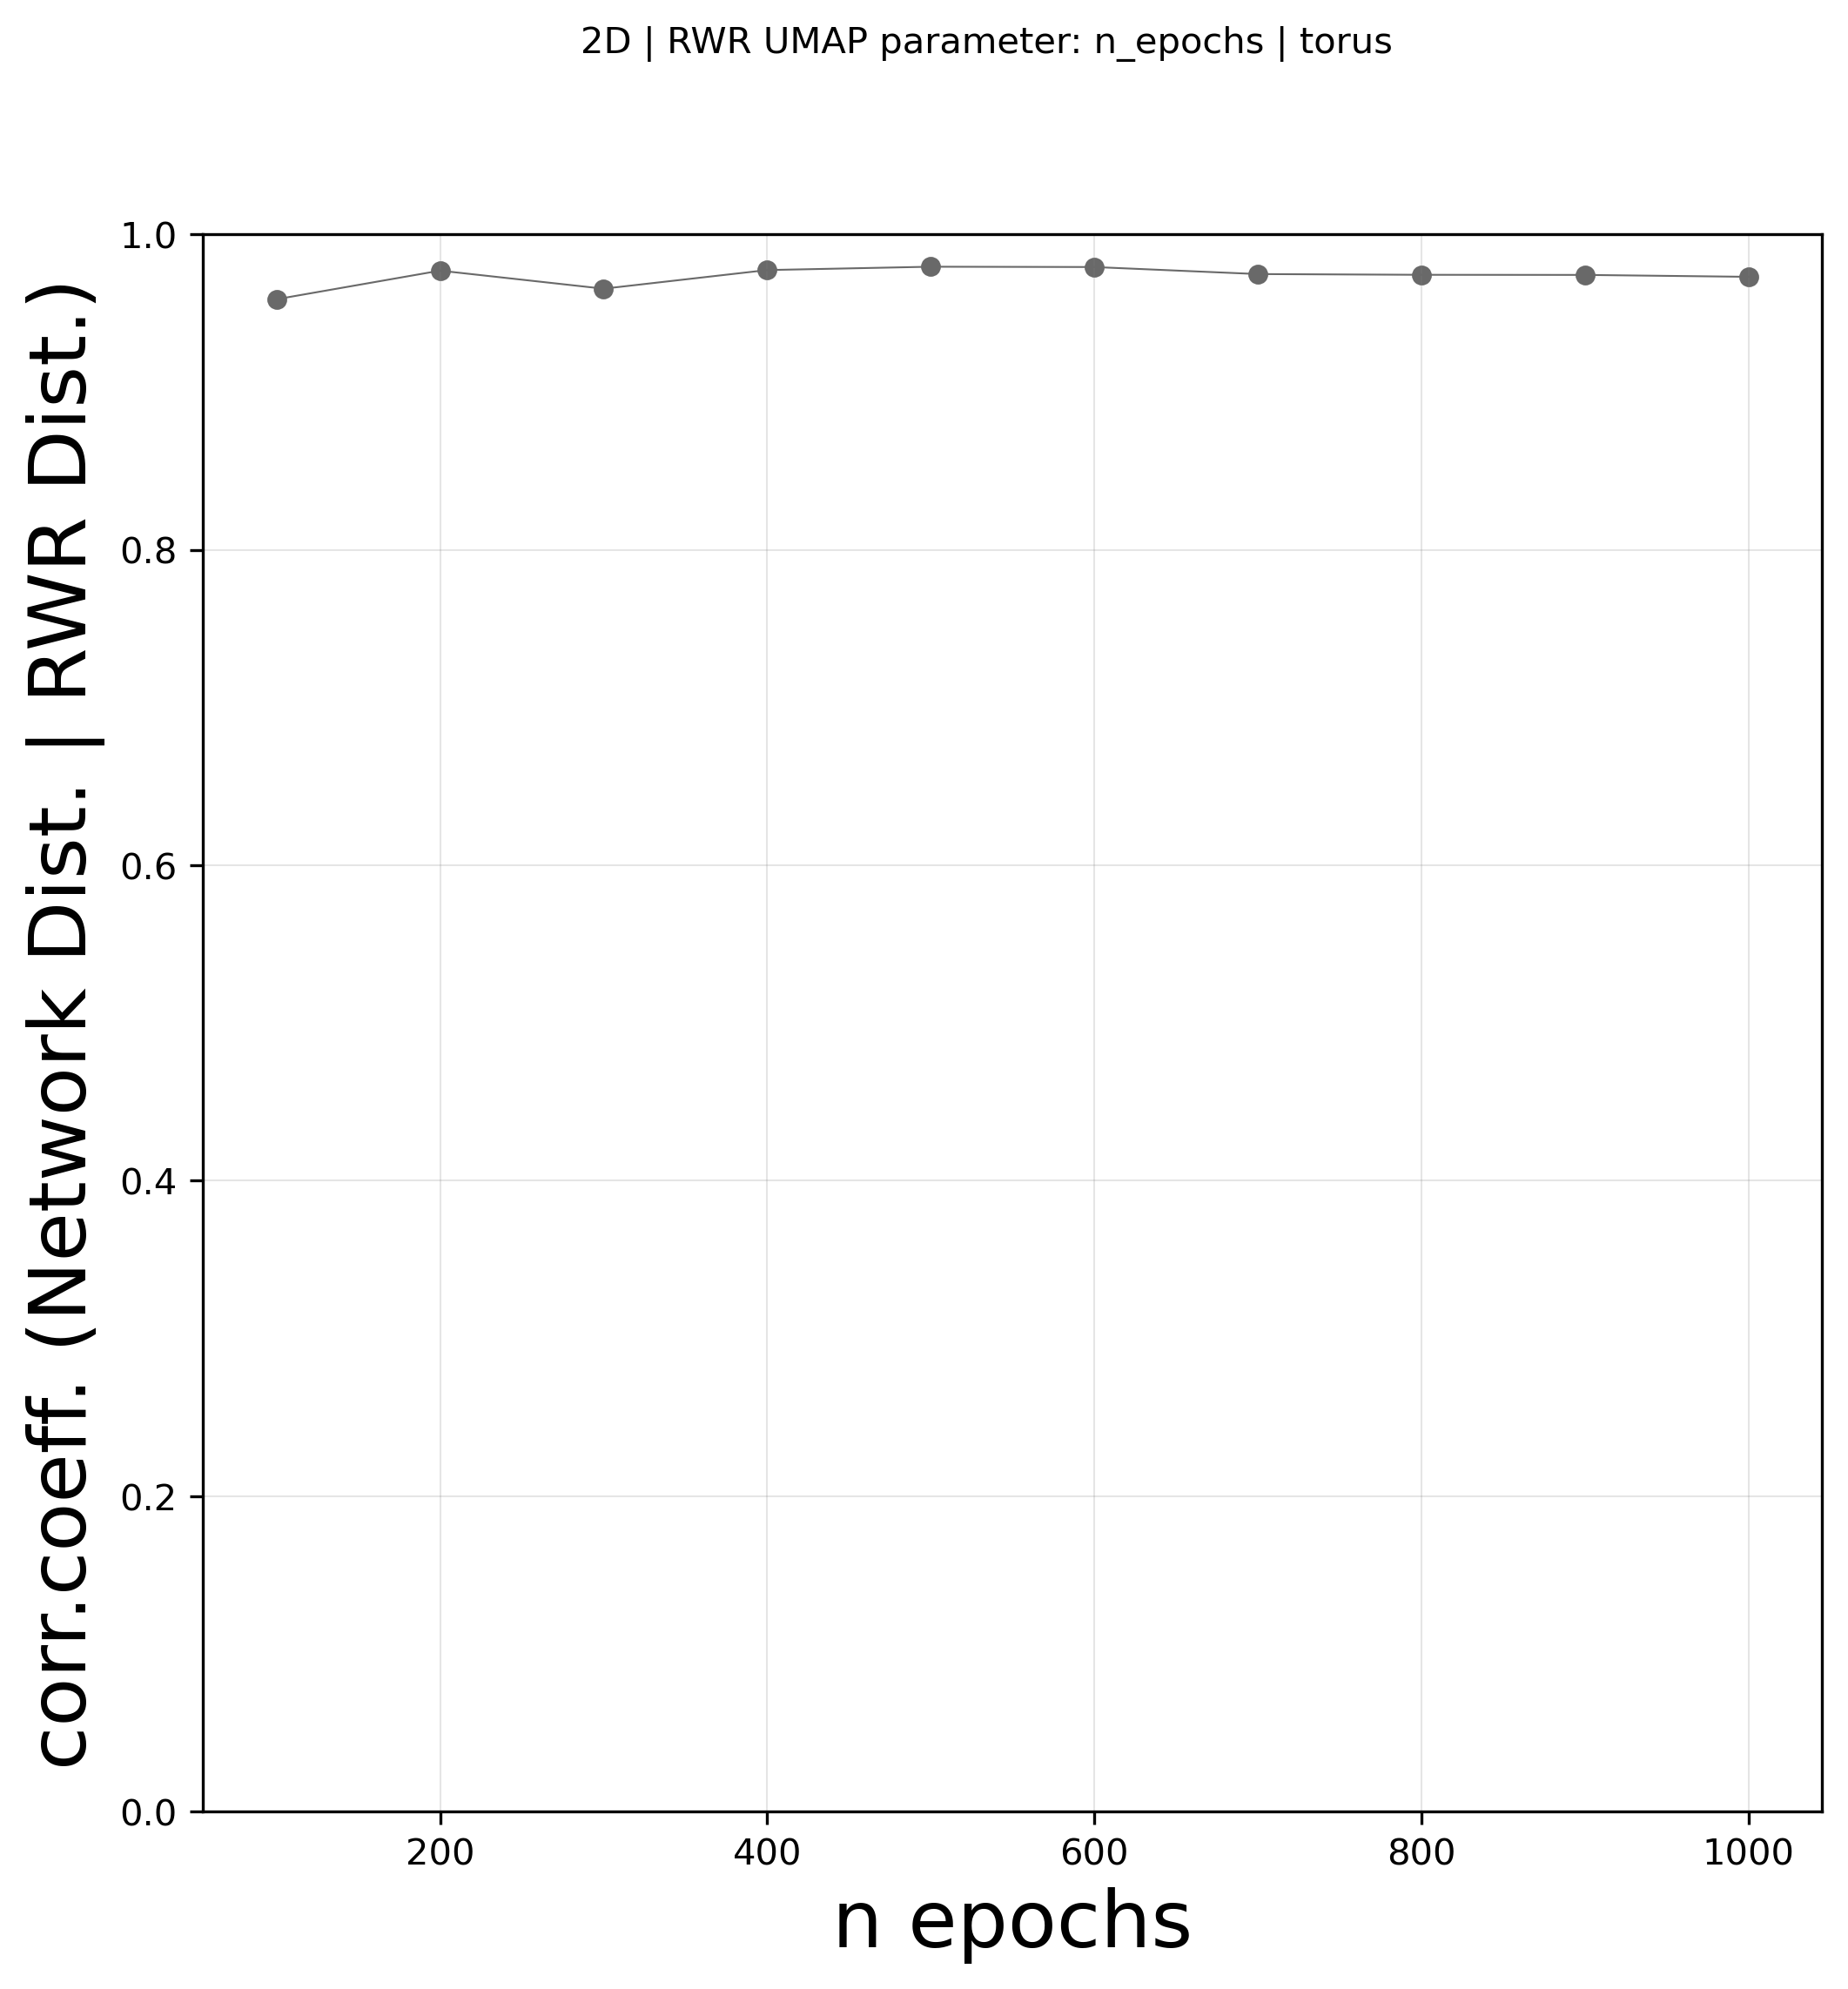

In [94]:
x = list(d_rwr_epochs.keys())
y = list(d_r_values_rwr_nep.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.suptitle('2D | RWR UMAP parameter: n_epochs | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)
plt.grid(True, c='grey', alpha=0.2, linewidth=0.5)

plt.xlabel("n epochs", fontsize=22)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=22)

plt.plot(x,y, '-', c = 'dimgrey', linewidth=0.5, alpha = 1.0)
plt.scatter(x,y, c = 'dimgrey', s = 20, alpha = 1.0)

fig.savefig('output_plots/benchmark/Correlation3D_nepochs_'+feature+'_'+organism+'.png')

In [95]:
#adjust parameters 

#-----------------------------
# INITIAL UMAP PARAMETERS:
#-----------------------------
n_neighbors = 20
spread = 1
min_dist = 0.1
metric = 'cosine'
lnr = 1
nep = 600

#### ------ LEARNING RATE ------
+ The initial learning rate for the embedding optimization

In [96]:
# LEARNING RATE 

lnr_list = [0.001,0.01,0.1,1,10,100,200,500,1000]

d_rwr_lnr = {}
d_r_values_rwr_lnr = {}

for i in lnr_list:
    
    start = time.time()
    A = nx.adjacency_matrix(G)
    FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
    FM_m = pd.DataFrame(FM_m_array)
    DM_rwr = FM_m.T

    umap_rwr_3D = embed_umap_3D(DM_rwr, n_neighbors, spread, min_dist, metric, learn_rate = i, n_ep = nep)

    posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
    posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

    df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

    x = df_posG.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    end = time.time()

    print('UMAP learning rate:', i)
    
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    
    walltime_rwr = s+m*60
    d_rwr_lnr[i] = walltime_rwr
    
    posG=posG_3D_complete_umap_rwr_norm
    dist_layout3D = {} 
    for p1,p2 in it.combinations(G.nodes(),2):
        dist_layout3D[(p1,p2)] = np.sqrt((posG[p1][0]-posG[p2][0])**2+(posG[p1][1]-posG[p2][1])**2+(posG[p1][2]-posG[p2][2])**2)

    dist_network_mod = {}
    for j,m in dist_network.items():
        if j in dist_layout3D.keys():
            dist_network_mod[j]=float(m)

    d_plot_layout = {}
    for spldist in range(1,int(max(dist_network_mod.values()))+1):
        l_s = []
        for k, v in dist_network_mod.items():
            if v == spldist:
                l_s.append(k)
        l_xy = []
        for nodes in l_s:
            dxy = dist_layout3D[nodes]
            l_xy.append(dxy)
        d_plot_layout[spldist] = l_xy

    l_medians_layout = []
    for k, v in d_plot_layout.items():
        l_medians_layout.append(statistics.median(v))

    x = np.array(range(1,int(max(dist_network_mod.values()))+1))
    y = np.array(l_medians_layout)
    r_layout = np.corrcoef(x, y)

    print('GLOBAL (RWR) Pearson Correlation Factor: ', r_layout[0][1])

    d_r_values_rwr_lnr[i] = r_layout[0][1]    

UMAP learning rate: 0.001
Execution Time: 00:00:15
min: 0 sec: 15
GLOBAL (RWR) Pearson Correlation Factor:  0.9729751114489029
UMAP learning rate: 0.01
Execution Time: 00:00:14
min: 0 sec: 14
GLOBAL (RWR) Pearson Correlation Factor:  0.9743833397403121
UMAP learning rate: 0.1
Execution Time: 00:00:15
min: 0 sec: 15
GLOBAL (RWR) Pearson Correlation Factor:  0.9791614509957828
UMAP learning rate: 1
Execution Time: 00:00:15
min: 0 sec: 15
GLOBAL (RWR) Pearson Correlation Factor:  0.9792491817291278
UMAP learning rate: 10
Execution Time: 00:00:15
min: 0 sec: 15
GLOBAL (RWR) Pearson Correlation Factor:  0.9626050835587399
UMAP learning rate: 100
Execution Time: 00:00:15
min: 0 sec: 15
GLOBAL (RWR) Pearson Correlation Factor:  0.9761380556095252
UMAP learning rate: 200
Execution Time: 00:00:17
min: 0 sec: 17
GLOBAL (RWR) Pearson Correlation Factor:  0.9758649448096497
UMAP learning rate: 500
Execution Time: 00:00:15
min: 0 sec: 15
GLOBAL (RWR) Pearson Correlation Factor:  0.9661555194339211


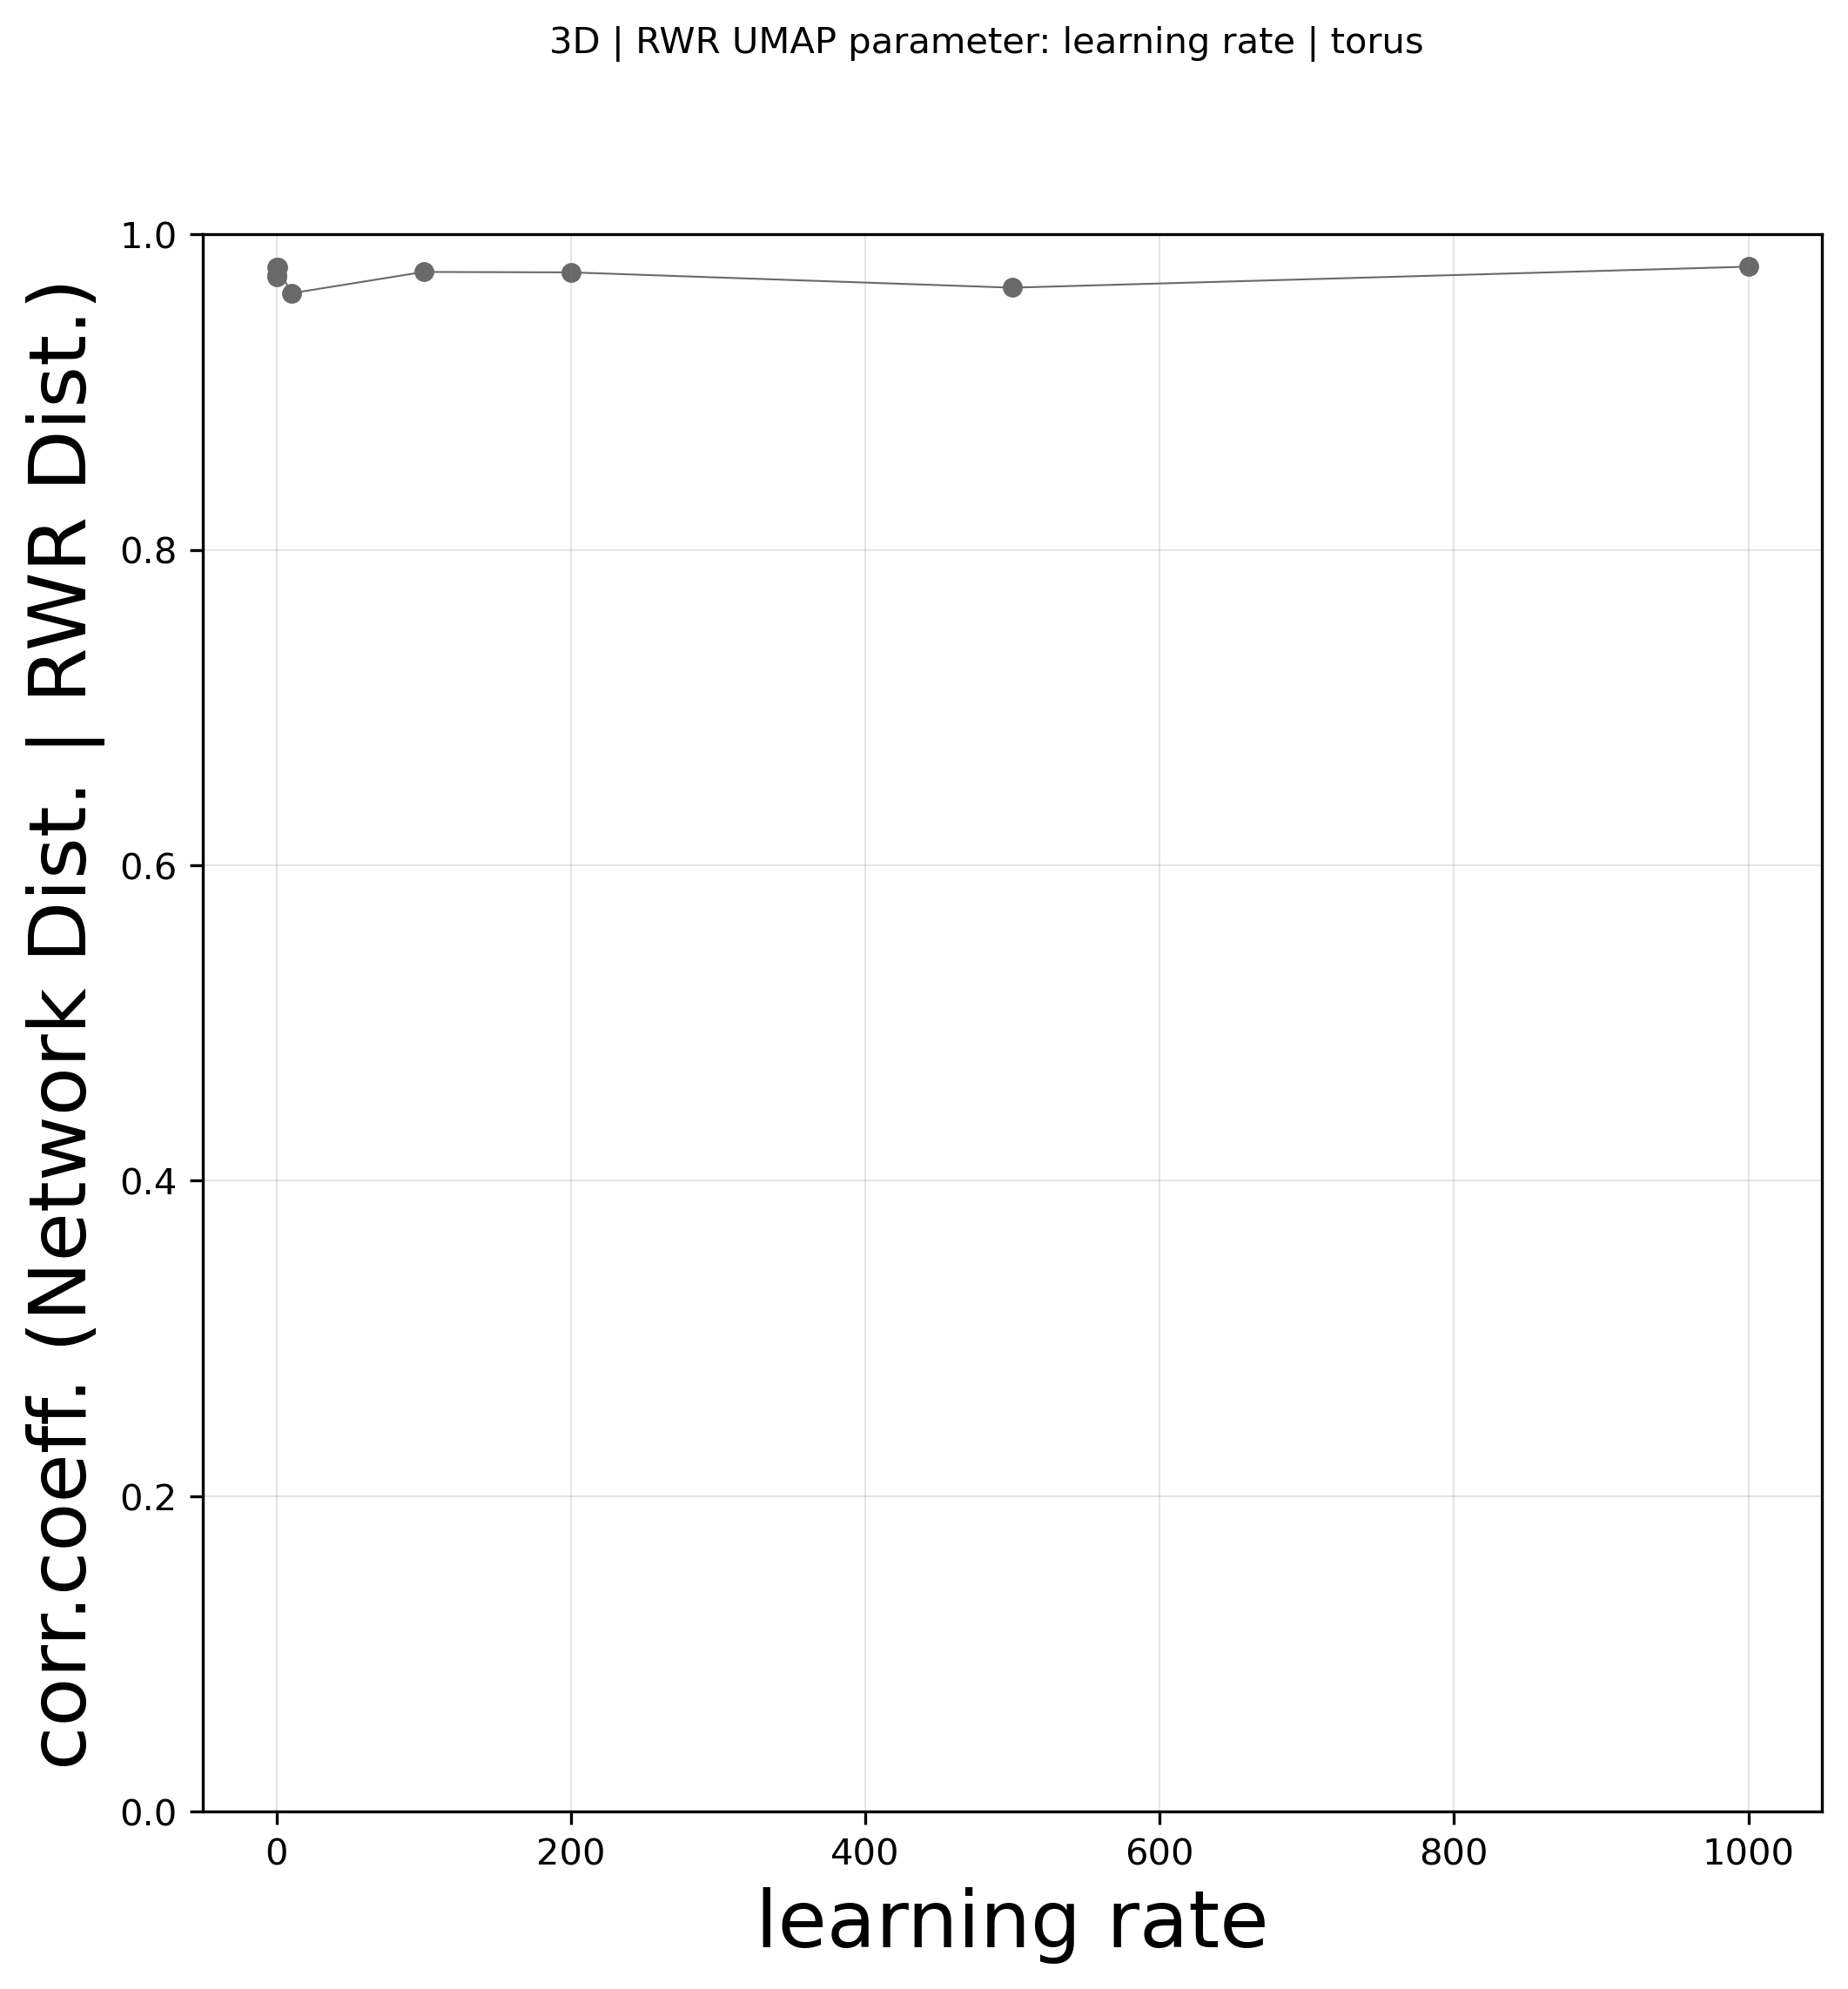

In [97]:
x = list(d_rwr_lnr.keys())
y = list(d_r_values_rwr_lnr.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.suptitle('3D | RWR UMAP parameter: learning rate | '+organism, fontsize=10)
plt.xlabel("learning rate", fontsize=22)
plt.ylabel("corr.coeff. (Network Dist. | RWR Dist.)", fontsize=22)
plt.ylim(ymin=0, ymax=1.0)
plt.grid(True, c='grey', alpha=0.2, linewidth=0.5)

plt.plot(x,y, '-', c = 'dimgrey', linewidth=0.5, alpha = 1.0)
plt.scatter(x,y, c = 'dimgrey', s = 20, alpha = 1.0)

fig.savefig('output_plots/benchmark/Correlation3D_learnrate_'+feature+'_'+organism+'.png')

In [ ]:
# GRID  
# parameters after testing 

n_neighbors = 8
spread = 0.9
min_dist = 0.5
metric = 'cosine'
lnr = 1
nep = 500


# TORUS 
# parameters after testing 

n_neighbors = 20
spread = 1
min_dist = 0.1
metric = 'cosine'
lnr = 1
nep = 600

# -----

# REST / OTHERS 

### SPRING 

In [893]:
# SPRING ITERATIONS cs. Correlation Coefficient (Network Dist / Layout Dist) 
feature = 'spring'
    
iterationslist = [10,50,100,500,1000,5000]

d_walltimes = {}
d_r_values = {}

for i in iterationslist:
    
    start = time.time()
    posG_spring2D = nx.spring_layout(G, iterations = i, dim = 2)
    
    df_posG = pd.DataFrame(posG_spring2D).T
    x = df_posG.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_spring2D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))
    
    end = time.time()
    print('Spring iter:', i)
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    print('----------------')
    
    walltime = s+m*60
    d_walltimes[i] = walltime
    
    dist_spring2D = {} 
    for (id1,p1),(id2,p2) in it.combinations(posG_spring2D_norm.items(),2):
        dx,dy = p1[0]-p2[0], p1[1]-p2[1]
        dist_spring2D[id1,id2] = np.sqrt(dx*dx+dy*dy)
    
    y_spring = list(dist_spring2D.values())
    x_spring = list(dist_network2D.values())
    
    gradient_spring, intercept_spring, r_value_spring, p_value_spring, std_err_spring = stats.linregress(x_spring,y_spring)
    d_r_values[i] = r_value_spring

Spring iter: 10
Execution Time: 00:00:01
min: 0 sec: 1
----------------
Spring iter: 50
Execution Time: 00:00:04
min: 0 sec: 4
----------------
Spring iter: 100
Execution Time: 00:00:08
min: 0 sec: 8
----------------
Spring iter: 500
Execution Time: 00:00:42
min: 0 sec: 42
----------------
Spring iter: 1000
Execution Time: 00:01:25
min: 1 sec: 25
----------------
Spring iter: 2000
Execution Time: 00:02:52
min: 2 sec: 52
----------------
Spring iter: 3000
Execution Time: 00:04:14
min: 4 sec: 14
----------------
Spring iter: 4000
Execution Time: 00:05:40
min: 5 sec: 40
----------------
Spring iter: 5000
Execution Time: 00:07:07
min: 7 sec: 7
----------------


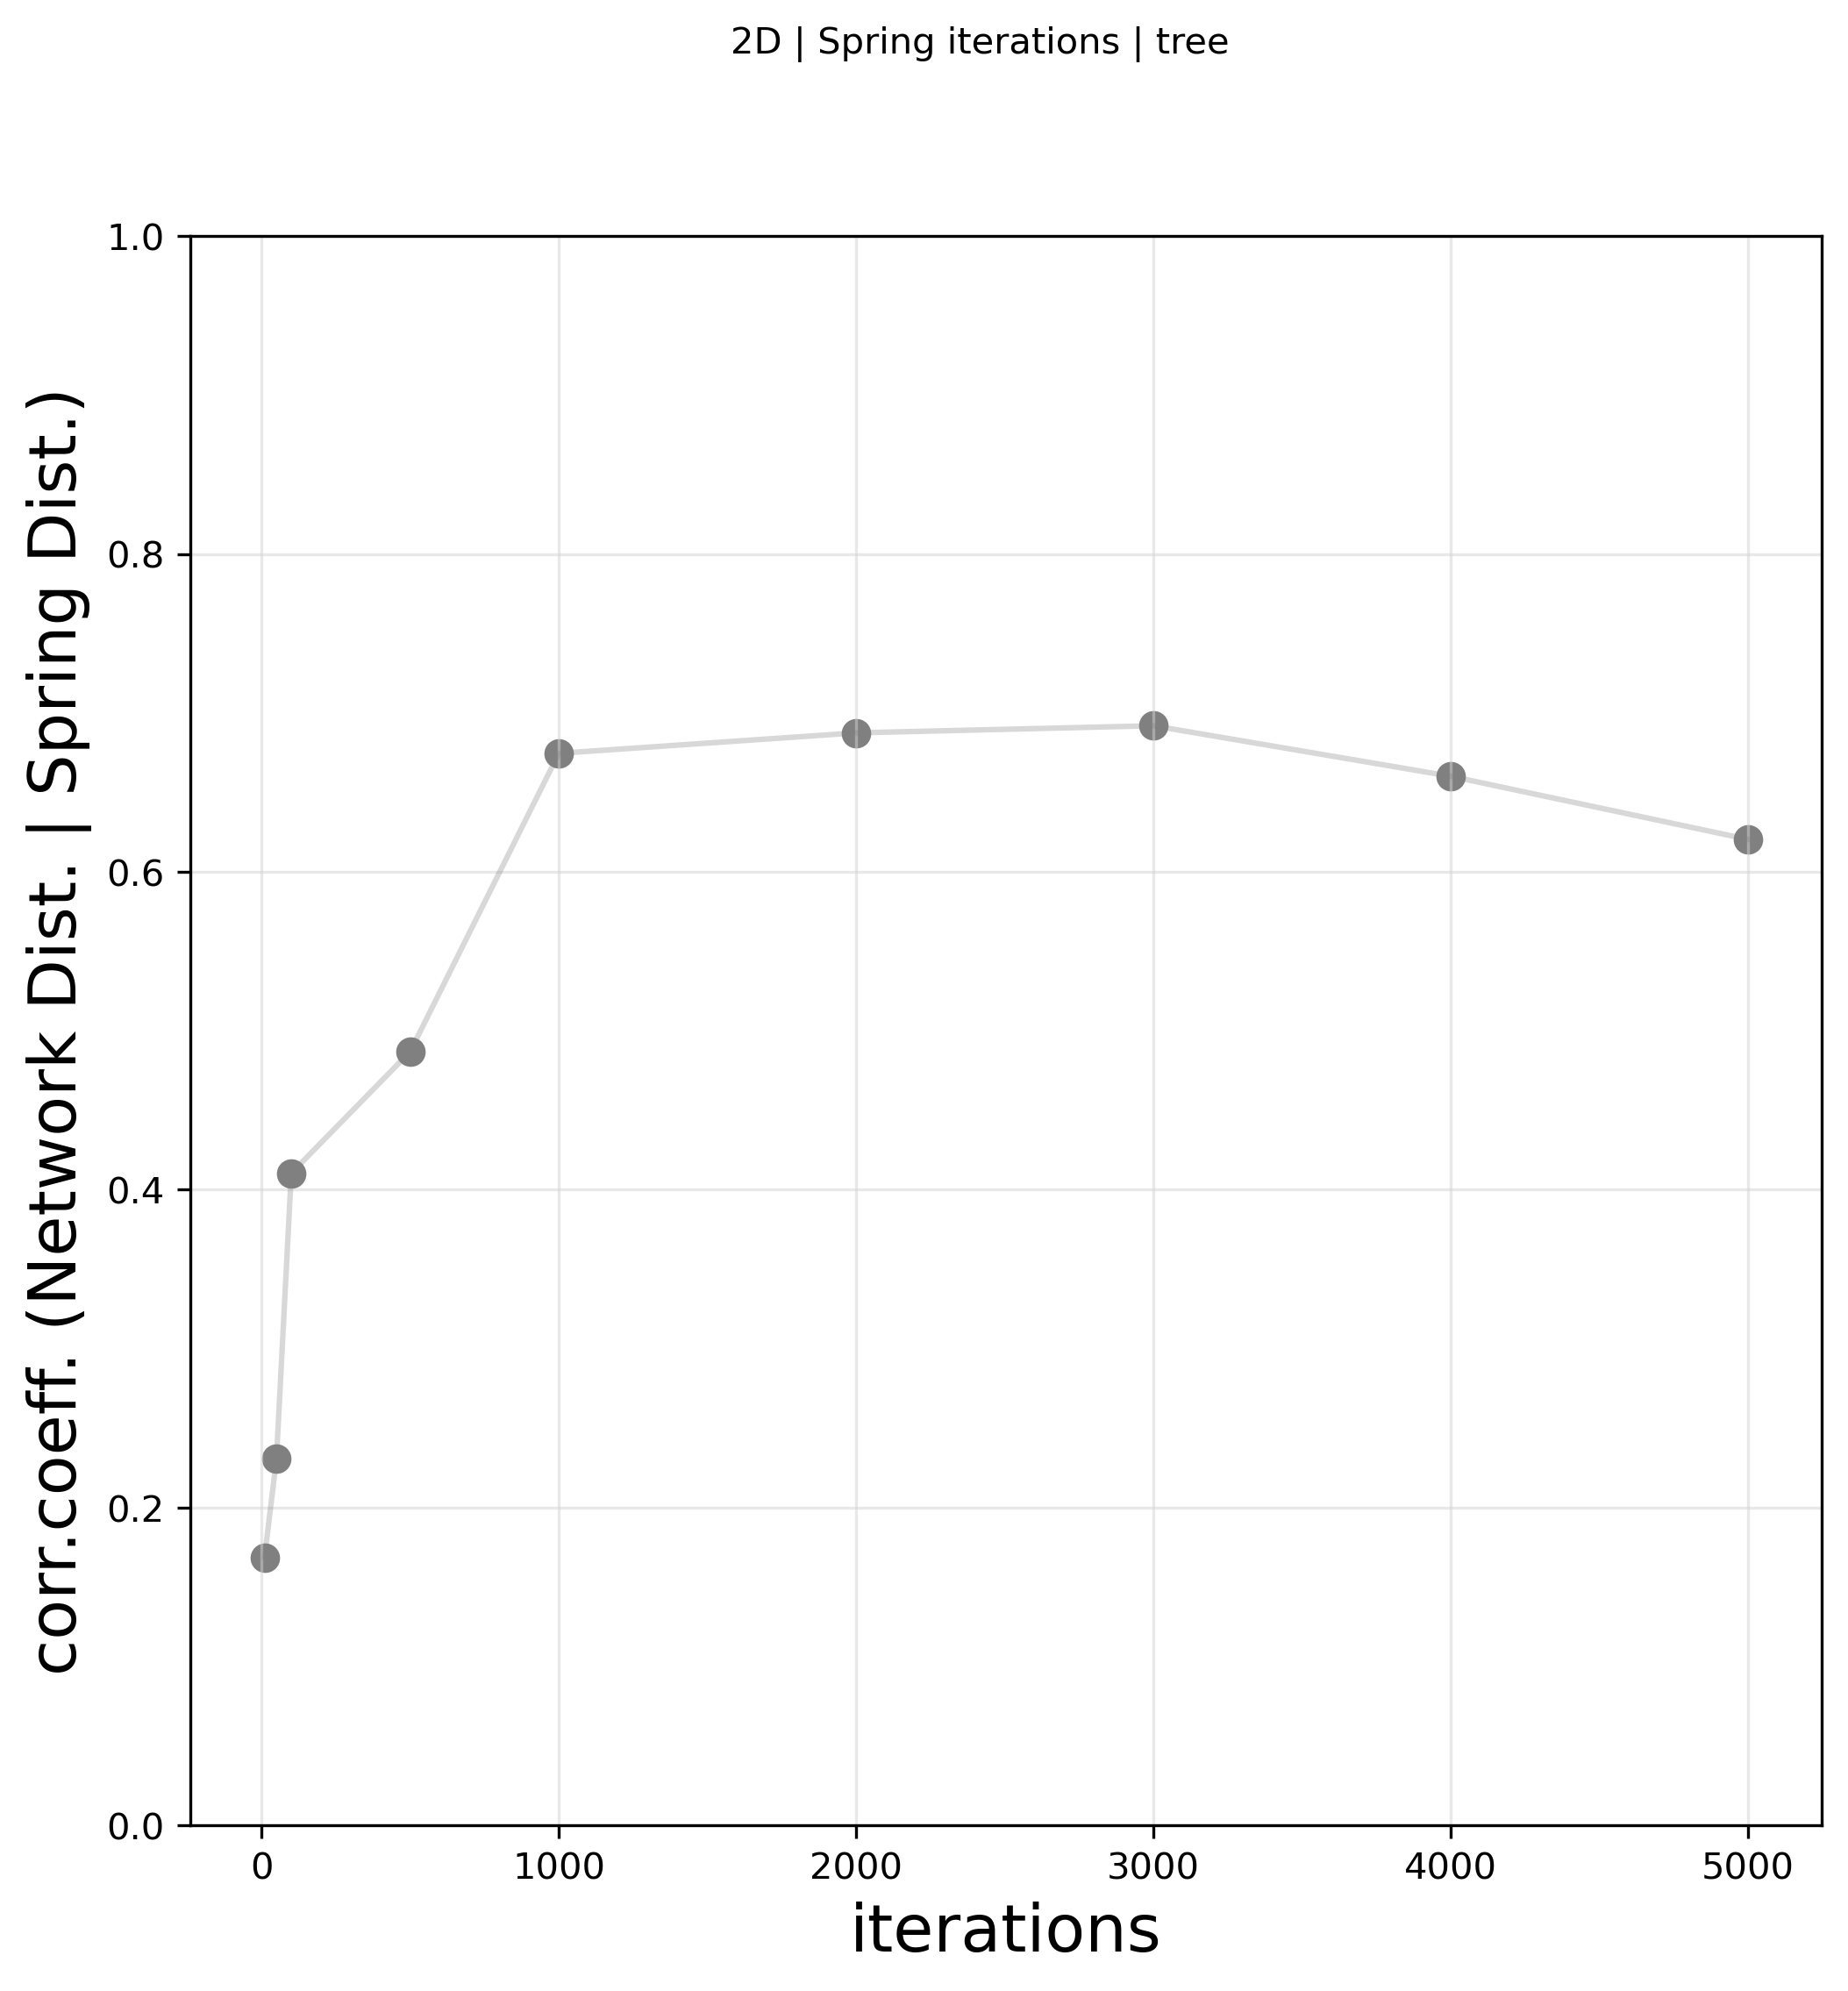

In [896]:
x_corr_spring = list(d_walltimes.keys())
y_corr_spring = list(d_r_values.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("iterations", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | Spring Dist.)", fontsize=labelsize)

plt.plot(x_corr_spring,y_corr_spring, '-', c = 'grey', alpha = 0.3)
plt.scatter(x_corr_spring,y_corr_spring, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | Spring iterations | '+organism, fontsize=10)
plt.ylim(ymin=0 ,ymax=1.0)

fig.savefig('output_plots/benchmark/Correlation_'+feature+'_'+organism+'.png')

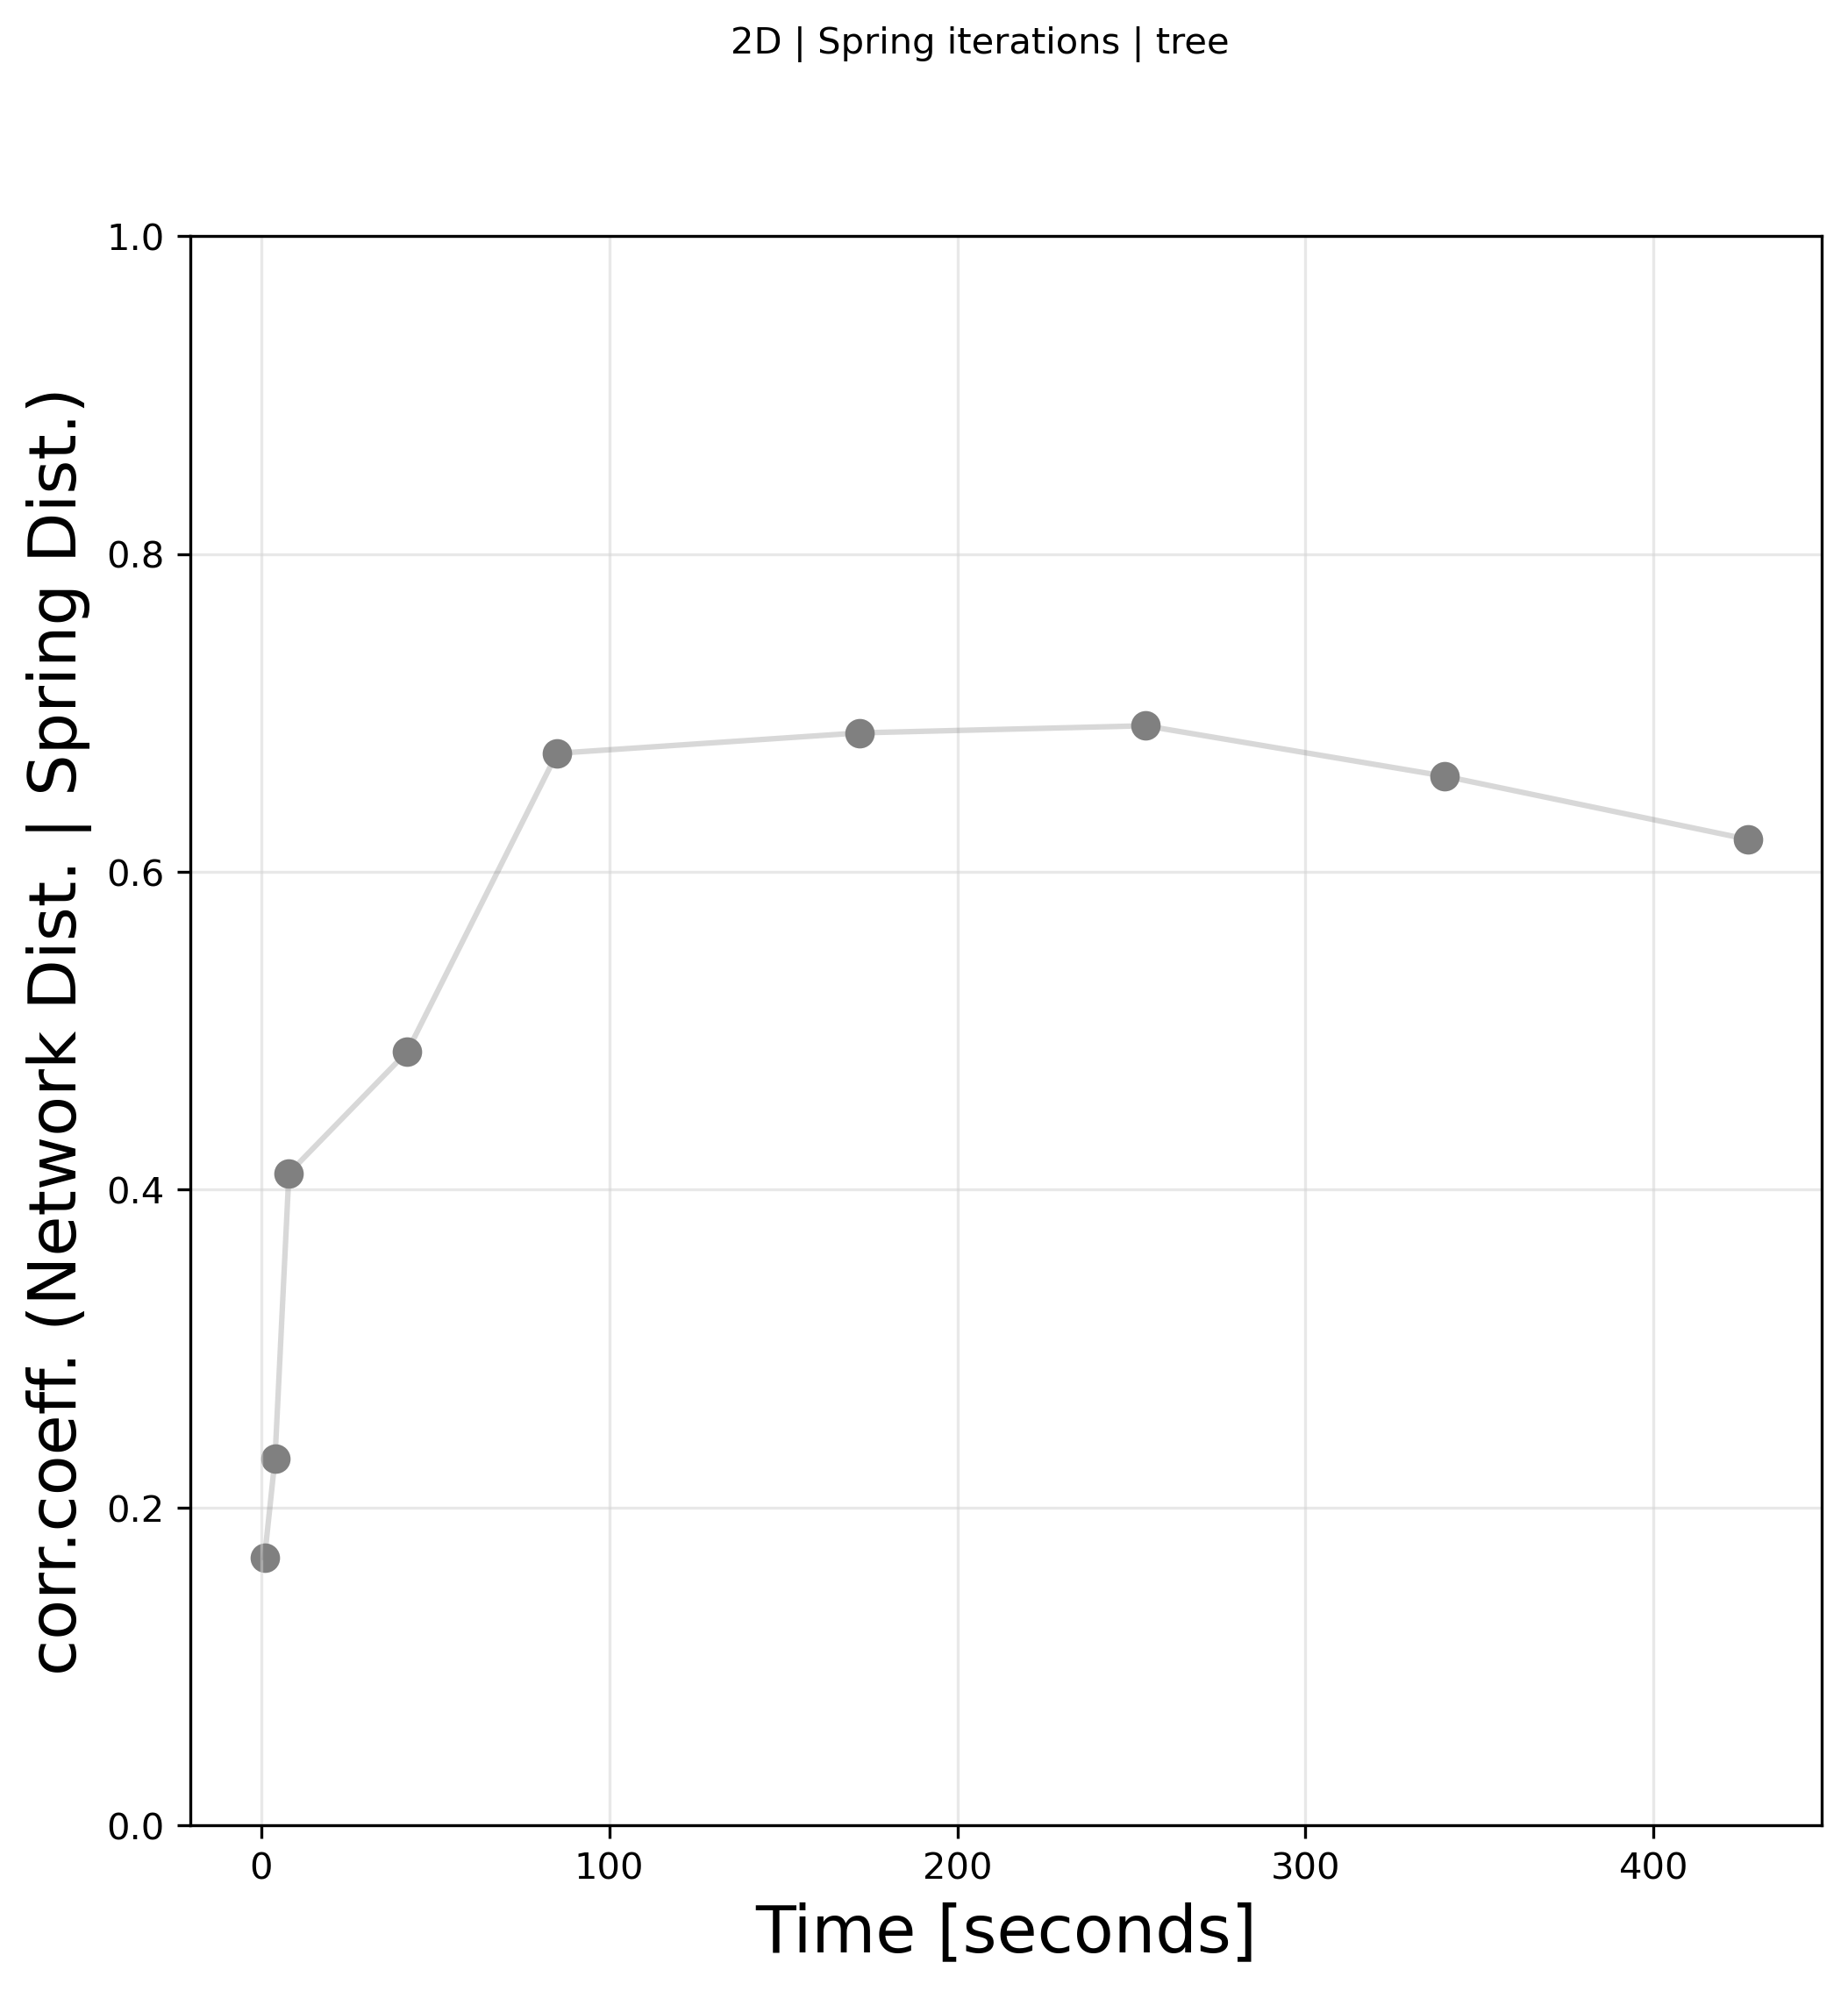

In [897]:
x_corr_spring = list(d_walltimes.values())
y_corr_spring = list(d_r_values.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("Time [seconds]", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | Spring Dist.)", fontsize=labelsize)

plt.plot(x_corr_spring,y_corr_spring, '-', c = 'grey', alpha = 0.3)
plt.scatter(x_corr_spring,y_corr_spring, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('2D | Spring iterations | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/benchmark/Correlation_Time_'+feature+'_'+organism+'.png')

### SPRING 

In [820]:
feature = 'spring'

iterationslist = [10,50,100,500,1000,2000,3000,4000,5000]

d_walltimes = {}
d_r_values = {}

for i in iterationslist:
    
    start = time.time()
    posG_spring3D = nx.spring_layout(G, iterations = i, dim = 3)
    
    df_posG = pd.DataFrame(posG_spring3D).T
    x = df_posG.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_posG_norm = pd.DataFrame(x_scaled)

    posG_spring3D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))
    
    end = time.time()
    print('Spring iter:', i)
    m,s = exec_time(start,end)
    print('min:',m, 'sec:',s)
    print('----------------')
    
    walltime = s+m*60
    d_walltimes[i] = walltime
    
    dist_spring3D = dict()
    for (id1,p1),(id2,p2) in it.combinations(posG_spring3D_norm.items(),2):
        dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
        dist_spring3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)
    
    y_spring = list(dist_spring3D.values())
    x_spring = list(dist_network3D.values())
    
    gradient_spring, intercept_spring, r_value_spring, p_value_spring, std_err_spring = stats.linregress(x_spring,y_spring)
    d_r_values[i] = r_value_spring

Spring iter: 10
Execution Time: 00:00:00
min: 0 sec: 0
----------------
Spring iter: 50
Execution Time: 00:00:04
min: 0 sec: 4
----------------
Spring iter: 100
Execution Time: 00:00:09
min: 0 sec: 9
----------------
Spring iter: 500
Execution Time: 00:00:43
min: 0 sec: 43
----------------
Spring iter: 1000
Execution Time: 00:01:24
min: 1 sec: 24
----------------
Spring iter: 2000
Execution Time: 00:02:41
min: 2 sec: 41
----------------
Spring iter: 3000
Execution Time: 00:04:25
min: 4 sec: 25
----------------
Spring iter: 4000
Execution Time: 00:05:18
min: 5 sec: 18
----------------
Spring iter: 5000
Execution Time: 00:06:52
min: 6 sec: 52
----------------


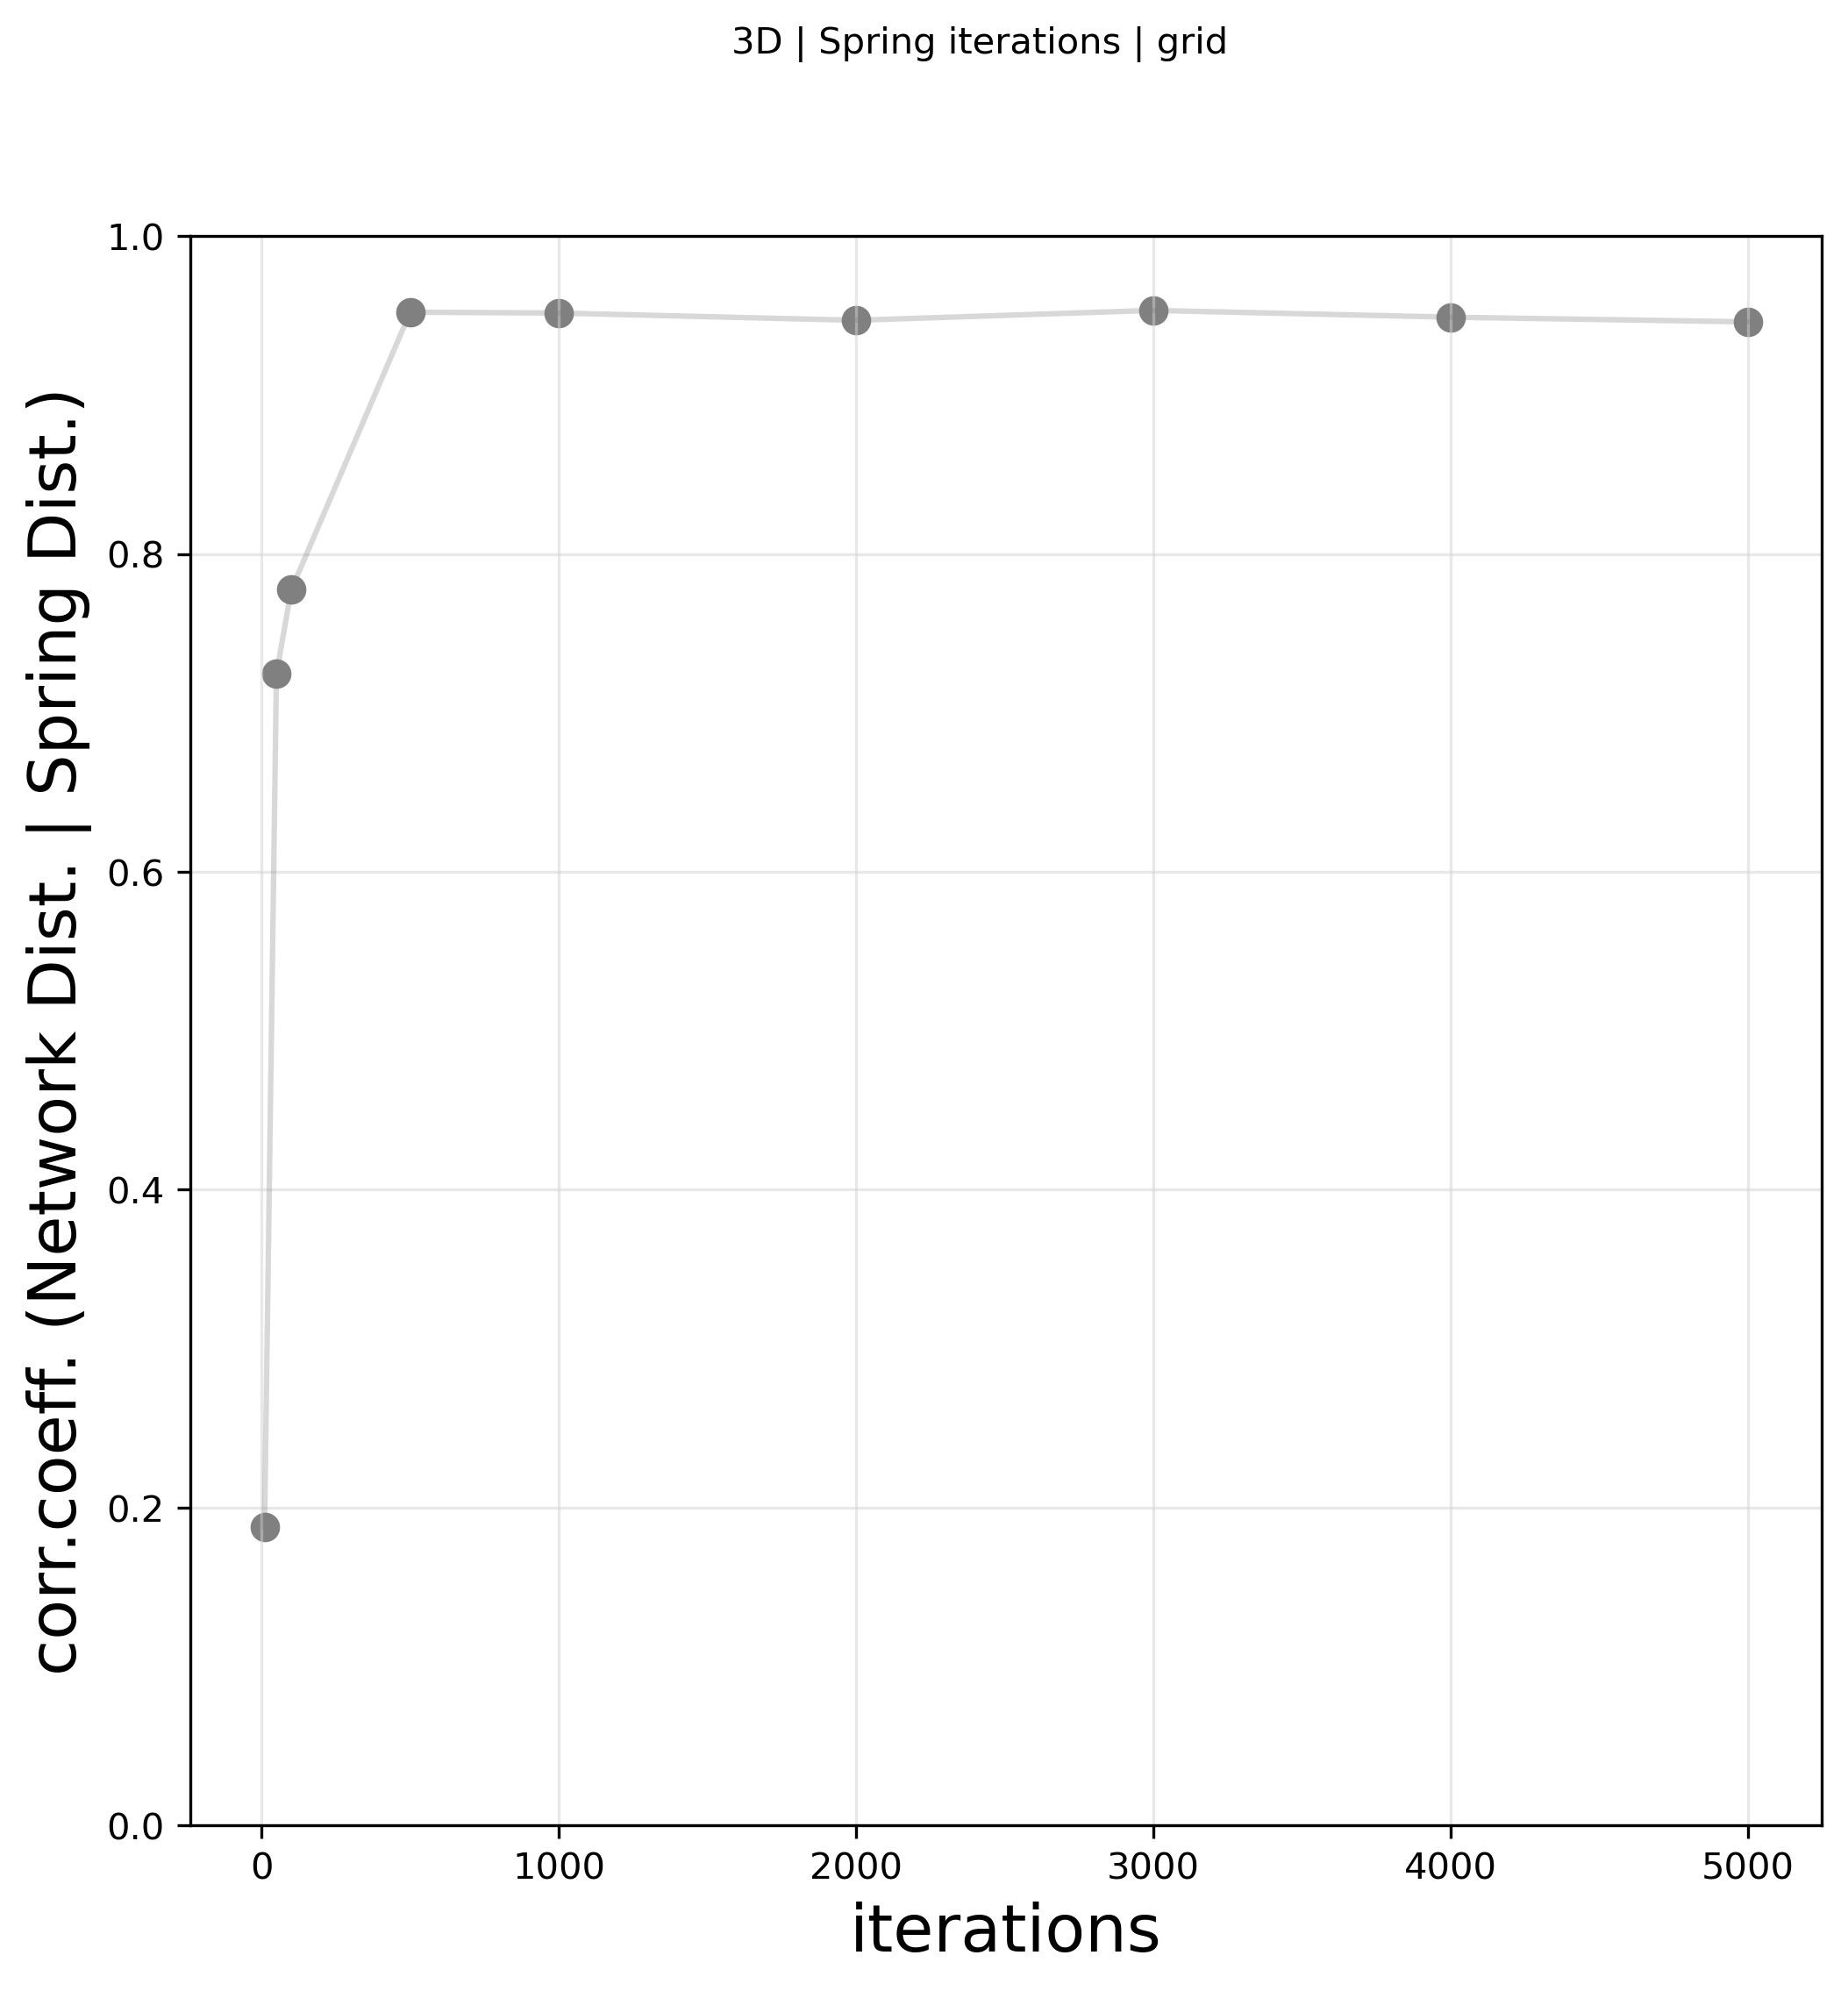

In [823]:
x_corr_spring = list(d_walltimes.keys())
y_corr_spring = list(d_r_values.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("iterations", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | Spring Dist.)", fontsize=labelsize)

plt.plot(x_corr_spring,y_corr_spring, '-', c = 'grey', alpha = 0.3)
plt.scatter(x_corr_spring,y_corr_spring, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('3D | Spring iterations | '+organism, fontsize=10)
plt.ylim(ymin=0 ,ymax=1.0)

fig.savefig('output_plots/benchmark/Correlation3D_'+feature+'_'+organism+'.png')

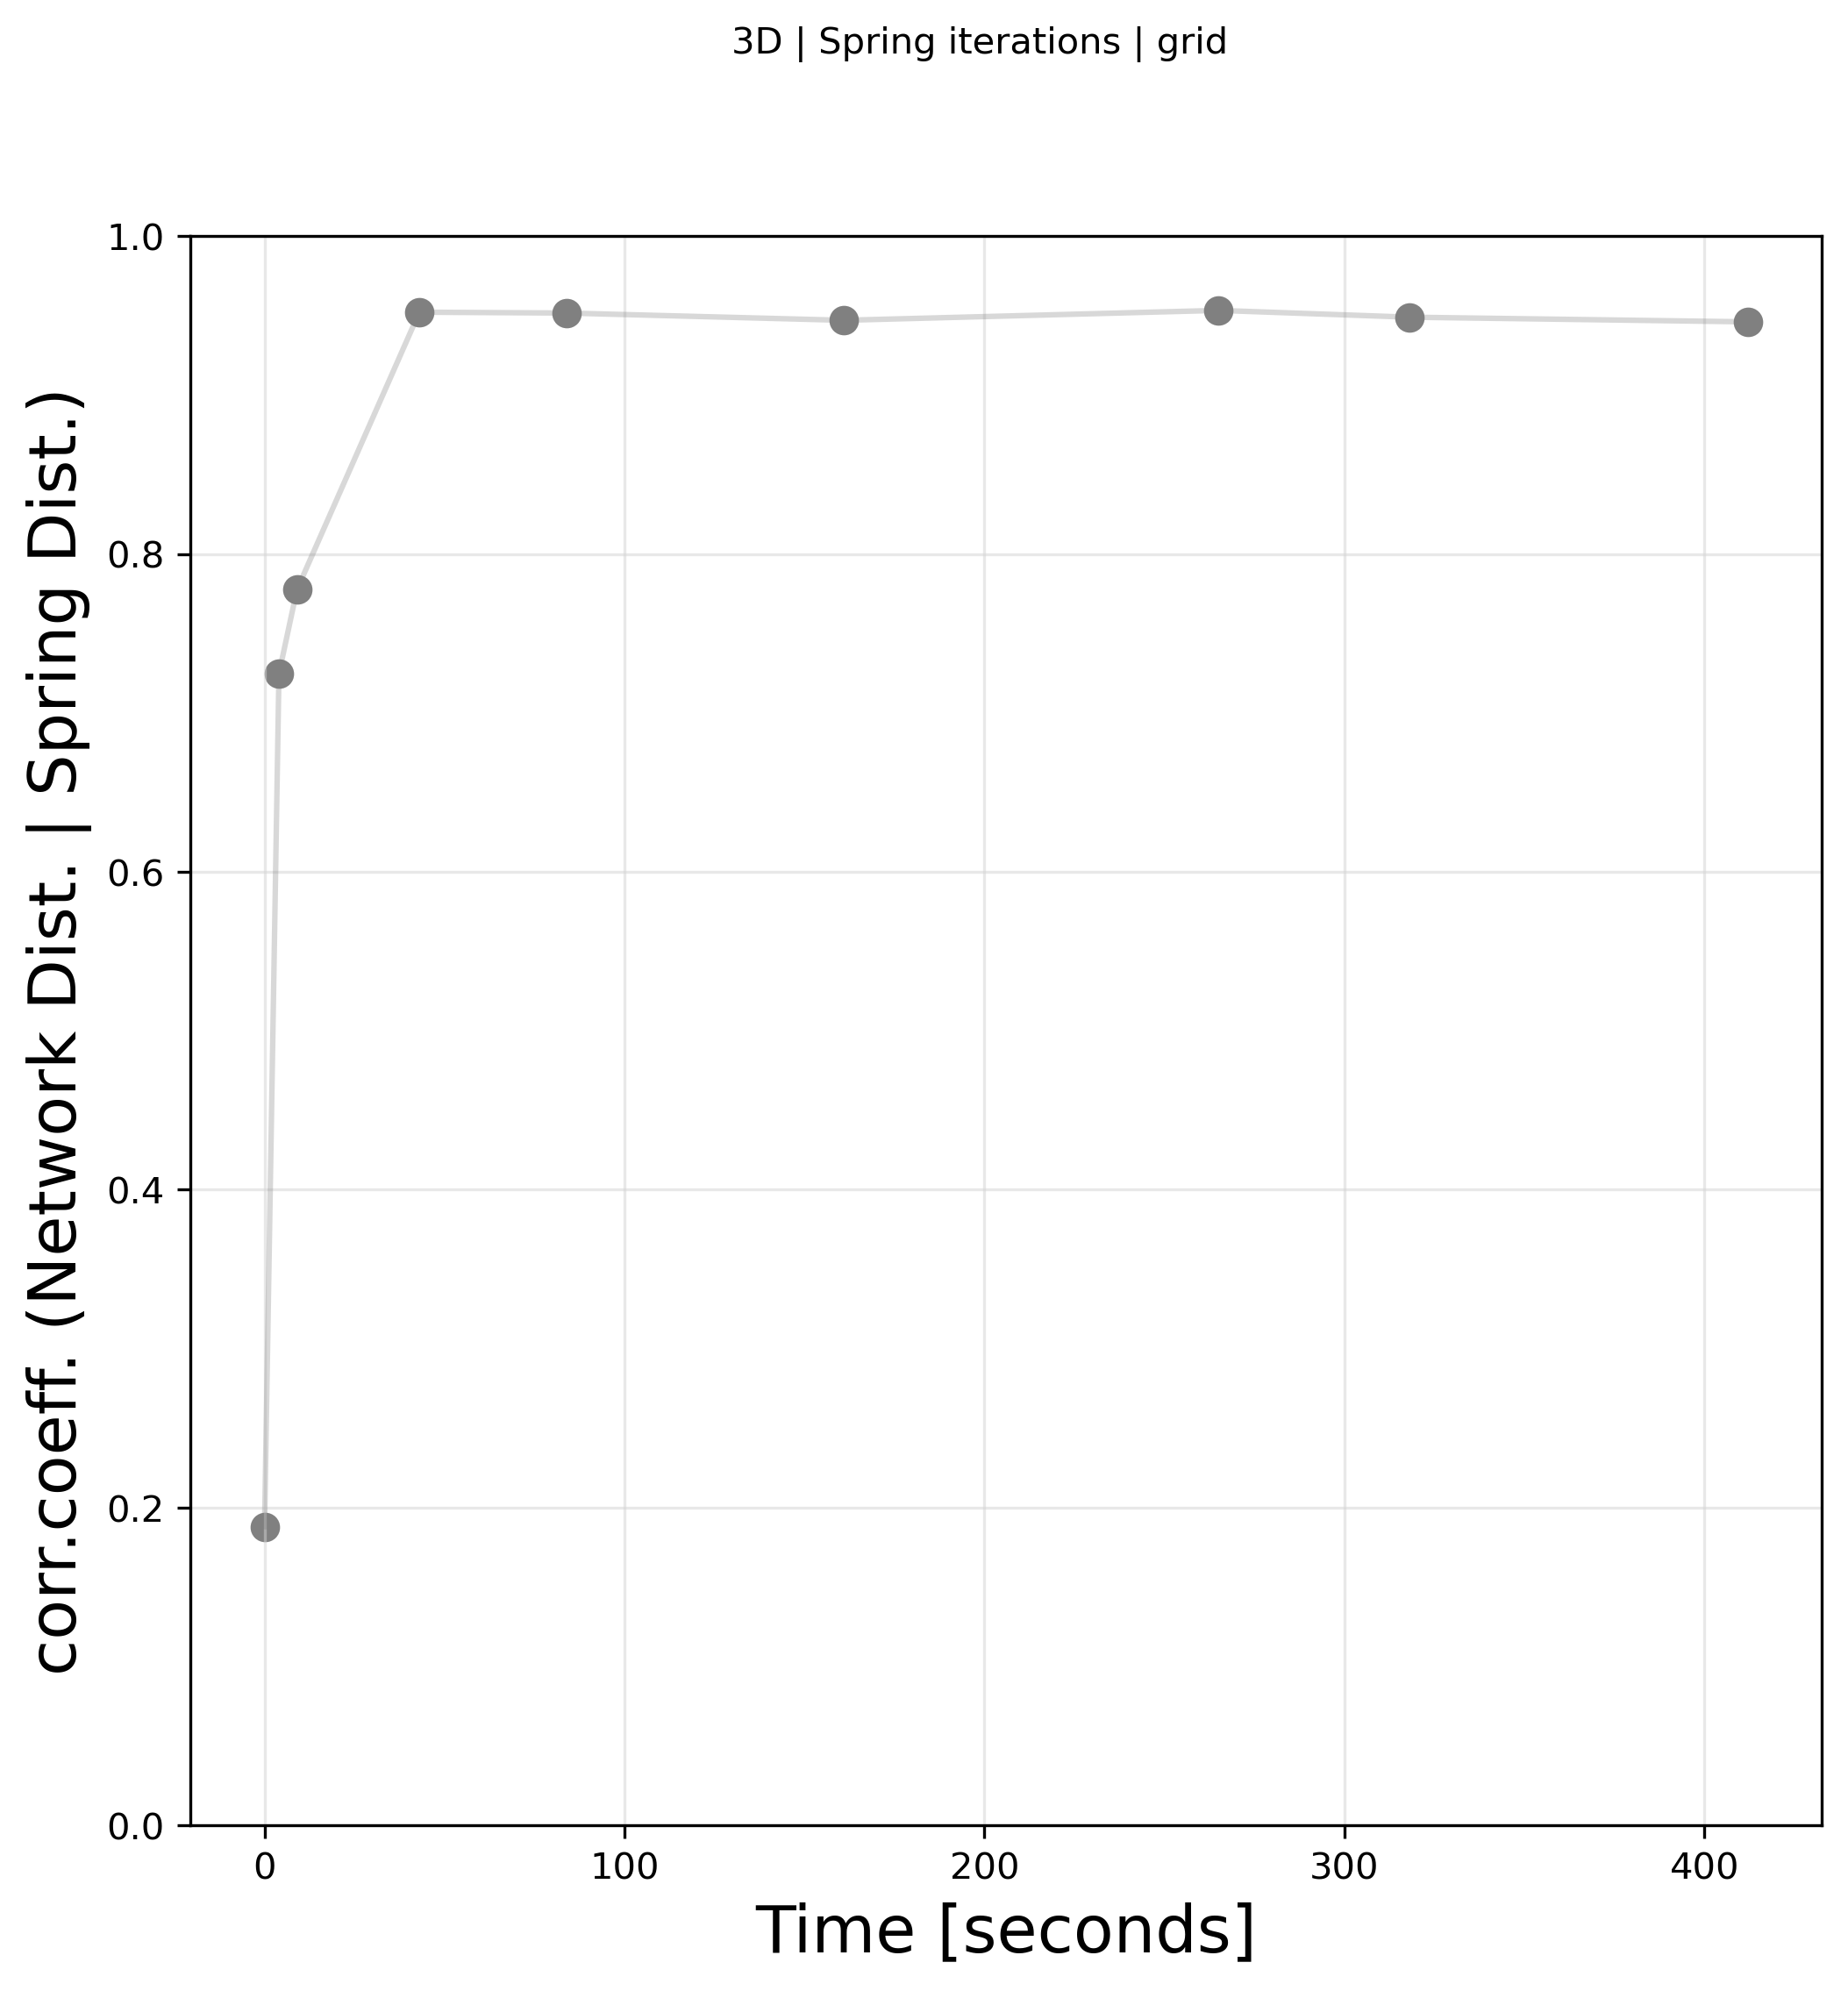

In [824]:
x_corr_spring = list(d_walltimes.values())
y_corr_spring = list(d_r_values.values())

fig = plt.figure(figsize=(8,8), dpi=300)

plt.xlabel("Time [seconds]", fontsize=labelsize)
plt.ylabel("corr.coeff. (Network Dist. | Spring Dist.)", fontsize=labelsize)

plt.plot(x_corr_spring,y_corr_spring, '-', c = 'grey', alpha = 0.3)
plt.scatter(x_corr_spring,y_corr_spring, c = 'grey', s = 50, alpha = 1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.suptitle('3D | Spring iterations | '+organism, fontsize=10)
plt.ylim(ymin=0, ymax=1.0)

fig.savefig('output_plots/benchmark/Correlation3D_Time_'+feature+'_'+organism+'.png')